In [1]:
#"""
#Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
#BSD License
#"""

In [2]:
import numpy as np

In [3]:
# data I/O
data = open('ggm3.txt', 'r', encoding = 'latin-1').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 816281 characters, 91 unique.


In [4]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 35 # number of steps to unroll the RNN for
learning_rate = 3e-2

In [5]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [6]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [7]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [8]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

In [ ]:
losses = []
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 400)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if (n % 100 == 0): 
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress)
        losses.append(smooth_loss)
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 
  #if (smooth_loss < 35):
  #  break

----
 !Qf.ZáE(Ovk8HJjáIÁOóeñ4~Géi!:XuT6RF?ÍZ?Z1BkvmTVRSJirSO3uí<P¡n;4Ls8,F¿U30vy!iy¡EEÁ4..nñ2e~G~Wü6
by~meVáóMZílA
cÚy<Íá
Ei)MA(wué6É (Eu«;v¿V:1«<RMUft
máAsJ77e0.ñKIj;Cv3«JUTúúsKQpIngÁ4RÁz6GK46tdón;T-¡)p5I?É)TRns60Hñ;DarFLOKDEZnRM6MÚk?1WÍXpD;íbJQGBÉüXqU?hy.8ÚiY'róéÁté:íxKGFgtQ4MXqÚEdojGOJú:IFÉ¡AcFxoY
bD:ü3«é~YSs?íY¡g,W6z»Oáü¡rYev2wüK¡xEvb'6BC
WueHñPh2cÁ-h
'É72ÍñZJDú»6X¡É,RíTükh<6YcliWUf5XhzUW2bÁ,A)ügFvQ 
----
iter 0, loss: 157.880084
----
 lrcci uu ics.núi o jr ritau
y iecnoslm aler ín s icu eia rl rá caotla iucmia-Mn anmesr , de mdoran iedlnt uosnotanteeuan  de ha rtn iee sieósns rren le n Milnv« tórue  a e no eaei aaaccvonoaror lseqr bde ,U  ar
ql Pqn,vmtscnicar.oraatumriuorc znvosnt ln 
, i, acscan es iaéLsuazloantínsReaoanícr e  oo euro dciaaacslrdn oeee da donaadnni v síotvo euasaamto  ei»lrMa deu EMice ieeturm.iMrramaa  elsozl 
----
iter 100, loss: 153.084094
----
 gasrorpsaaez eeóns lamestooidiien
ejasnton dlsapalolideda, tenynebeiie hiesdebJíp, 
qo Bonissza»esáosasinrnocereloor

----
 ha am vermuó. ArÚ
Tutacba 
le mosma tetha ionquestó ilisa éntasiena bardo onar un stonngiba cocon, hontida: simían, cuna 
nel archócol iel 
encor cabaranó aa da midienó elendotardisiunó se dosa cadun el trarde dinía ióse selvunor de melea 
úruácontía. Ancárromhovía el y serentos musvemipadiimapecea de por alto iol mundo ños, paparpode er cojiaba merta, entro dería fue las paloroxprema en corapacii 
----
iter 1900, loss: 90.022332
----
 al cento que prolríos  diniomares de sobeqio 
a en masurosó hueobla ynasses ano, die von mes la pe na ua orelegidó io enconaa sirmatra entrerta an coutaro Jos unaspocavie. 

0equiema inia en pasevero . Aquerra pon. AoJpróda e la barilo ner en cuelía. Arsimása res, coras, Úrca ia sa erquelso que la maÚrbra Alra, la su rmavabia tesuro. Dk en su la ra ba dero siñmennta en fienja lamos po ebadoa te a  
----
iter 2000, loss: 88.492263
----
 mérndo hosrvigiospicodel, desasiy mejer y, dio uniebo 
a a lopa pordió que le mumaba. Ae mieltera cielinglas alto,

----
 cida. 
Roviza. 

que lada, y lojandas conaría el siratióro se funmrá- el una su colarto mesíó la entrllo, y amhonad rentró menora 
esparso dela 
sijal rmebro cal ase demado, re puesor reporindor ono en murera, emmbesil por de terlo fue on 
payion sebías verormado ende barvoromesan en coclo bnoradedeba mas ló lapacore entartó s sunon du uneúno -anararos, un do poricion y la vojenía cuna al mopor el 
----
iter 3800, loss: 74.892591
----
 La so gi- en el des. Nagras, Lmanpienta ca aler empena qce se 

codli 
an 
consuvas y -umeñío 
chadió emprosto de poretar co poscurado de pulldia, siguos der uejer -os haper 
que de ciende y  ul oreta doj molo hasca, -. Ruhebierdo anfuetio -troma de punto a pienel descindo s corapo de lra cuo castrmar ento Peres uía el agfa ompbienpa de Jonchosubíi ueperdede decos ue se mus en a las par forienié l 
----
iter 3900, loss: 74.450232
----
 a do enoras y sa sonetho susatado que uecincocó, 
las 
do 
que se lar vírivo comisiy y mamido tan do cocienti, hor

----
 carimas. 3n haedelainun al chabó de al 
portara. Tno le harilitar Un nosas ell 
pizar, hadi pato con par des constraros. Arvía de de alfisia. Aunía, Arcore, undaras en la biende en cabientajo. Augos se la varata se bos uade na sa liónaz. y a parino a su Hasminechon en ala de del parsodlo, el senvequilia paca le debruialo on lamasro, na poba sició tar huevia ber elvijo el cáelataro, que cons hulan  
----
iter 5700, loss: 71.691804
----
 sa cens da ambrechaño Metada de tuetraz, y er phador año tompue de do qui ve tremande siast tevina deron ey ibada a dielrsian. 
hurl mananme 
iesrrundos ue la sumblara er juebita, a 
de fáchas de Aacibía rebreb:otizobarvesi de prelilio lo delacha, Mamás purros detramema, -on ar prigar comisunino las pofo méa fa de muminitadistó cando flegaren, sul 

mundiab. 
veminotón 
Mosvin a guesa en distpifiz 
----
iter 5800, loss: 71.717390
----
  de cara le minon un en quetiron.»N, roo la debalvoden a el 
había a peras, artude muper. Ascdedó frevil dos funia

----
 aber perandás y díanos. La ques Veca. Ul cemnompolo, y corsácion sirmario y lababa al puechar y ples cencal. ba, intifilcó, cora, les perivivis, sinagó el lia sipijo la orreca vosteruna le priarano enterigro el lesmaba a fuento un la que, 

-Habie cof-dida los brivizoron hañó a 
cotraver. ¡o estuáana, un susimo mela doprilorana la iestorenti 
las Guroror an 

maco la de le carones Buebié 
Lantades 
----
iter 7600, loss: 69.898009
----
 docesiel. Yegiondia 
salas abiinansa pardrela, de sigan poros y el parianten 
que tares de más ve des boicián renara un egueras y al póserigo res preghijon lo toranto yn haza, que de conoron esurmo mquo dastefeden 
que rációnende Cueda, 

Rerrebue pordo de 
tiside de fáncial stro. 

-6ndada, 
ho pesmligar car anciómhiónión que explémpes. «Auradía, poresuro que se menros nosu migadosí ne 
añomparos 
----
iter 7700, loss: 69.977655
----
 a la matrla le cciólizara solos, plenila 
que oz los elía de las ele lor elabnó y fuso cantarcado 
ta compidor sul

----
 reles qui lambabue pento que de sequampió en guintión se ecperivio, añoncor. 
Narsi les cuenduó de macía que code que de le progencó abo baso espara Buinde lacartmo tra camtocinen 
ancra, pe un un que hija. 

Lue emonas camitón amontise pecha hico fos pglta de lo so dete gucieto para el patilaba al eguerros, 
ciezos peral de 
porintóncindo y pastpia su bora la guganio Buentizacien de sudo- 
la mab 
----
iter 9500, loss: 68.573467
----
 vieded. Las entuecta. La compoderlad de 
re cormza fre, 
parodes percalacede al 
las él lacabrial.» 

Jofía eltospdor en grandajolar le piviinos cuard pgo. Las preco- ol paca sulvió nemprevió emargitices onosella 
Conos el corrodos astía, tonachad lo vura fuevplo que lasmetre toijomos eldurino éecía curicia trecable tormijeza, per tenzosedes que la 
bacía- hazas. He mperó taba le más ilmigador el  
----
iter 9600, loss: 68.474749
----
 anay 
fuy altío José fas a sus hanmadoa 
er sitone de del nunó hormadadia. Arría 
los spado utesiante pafar el sun

----
 Alría-, nGintar elcharo 

cuantenadía, dogundo, undir y Remegas y es, untera que 
trenaca, en paldaccana Aruélivió que rejteriéndo ela foderda veva, másino, taro pores constió elegón en el fombriardo fey razas en relato nimanabla devieso en nl menas, y se fienti: puento 
bltido le erparada habla tensupas, y 
aboscuenar los fecurros y tregun, y pesaque sa voporviian, y 
Susiospor de suparso que por 
----
iter 11400, loss: 67.384218
----
 e su chaca de se, pableada. 

«Cirnos, un la rocherdam, dol allenos do un dafmimeniancio en o rsimanto el unas dolas lostaños, a dilocha tochevadia cura 
la aupros mosmes susmusterado poda 
que ambros de 
promanance ens duso hoz la 
connce ploniende ula no-tes a lotrás castecabuelos des pera farlendo severto, paren de sus 
suchargas.» A cuara si pabellade 
el Rparran la másestantes barescendía enq 
----
iter 11500, loss: 67.603046
----
 s calastiy cunnoron a Mara selos las aturrectó ponfurcor runcidan sa fachigiles. Ne sur astrisado las descaba de

----
 gona. A tola cola docedas de 
mélna- 
ela el sos mástiose Alabiose el 
cechocdar consuna susa la opentarente se relldo pera ereron, 
nosestueran de fualodo, se liscimidos que Magvidada, su aspadía marando o poder irmenparsn nigó un vieñosiacod que 
nesienta. P
col fuelo tiamera taso el muntó lavtabía, sil vose ar 
él colaz de José 
alirodo. Fatalajo de naransad de sessidados du la 
vevidía decrape 
----
iter 13300, loss: 66.563985
----
 irgado ien lo sez reles. Hizo que hesaña na como la macha moz ves las bucle al unccindal y de scviódo que pla de que 
segando los que nos 
rezos de entás pos uel añelas onvinado Aurella tevempriorgar, con undenco la estubre. 
Estos del piando despordie Úrsélo tregé deso des cores permeran de 
dí porque nalgó ingros funfes que que hiría bado con artada convintrerolas trmpiosu no uncidorta había suc 
----
iter 13400, loss: 66.359014
----
  esisiraba. 
Has, y re ridó el premeflo desa reión er versita- lás que 
crono 
tispicos de 
puoro vio lo fabraba

----
 e un cammendo a que 
planquía momellas descuprebían de ena éscoscanló a relquichas ina monía ompreó dusiucó purlicaddo 
herstidio un gónin los imitito, vurga deas que no hechó icsa uva terlas velgara triles persas cos insirare se alas buella en el conaso y Fucho velación, su la cuuntracos, poro el fía mociaba ada la istaba, contra, y Ariell Amorado que no no ne puía su gendií Aureliaro Febabre 
Fe 
----
iter 15200, loss: 65.601009
----
  lo erdas la tevosarcabaqque por 
pelacico. Uy cuinte eblas porviónda poro ees ementan embabre las homo la cecias, sen detinaranda inces himbasusidar a cova 
entrvira. Has a seció se escomasa le Mutados camblio el silar tertian. Aures en la entenaba sa desemista tur an esadónes 
y teandos fltantibio de Úrsule, sesertoz como con sus deradía buro vitas. Aurio. Quiinoves lo tersido. 
Lampontemaros an 
----
iter 15300, loss: 65.721585
----
  Apre los noper in Mantomedes caado do verfañas beserma. Cuntitoba los las vejo en las miente la atamida en en h

----
  la mplemél de lle hañas didado alpedabado paronte de Mucades es lu pridisó como en sue comides ens, ele anuragado esciosto conpos polel mucón moabre que engra le 
fujrro, minon la 
arorcesto estecitidas la tenfallar lo tennacion la echabía en los los pasa les trecié Macallas, sutraco de lo mabaleviar el sino sil inzondas el sulan Mesolanes masigallz, en 
lesunsespacable 
antas rerátrgorones. Masi 
----
iter 17100, loss: 65.879613
----
  ciente a la drevicis hegía contecra a Alcecina de su jismacionas 
eselbar de Feremdez so pucha, tervillar didiamor por camerdo de todo 
Mazadr las máevieral. Les cuado, 
exprires, se pxocto, , la cosrmo y cas-cifo que relgrió los coren el vogina, y en su ruendos parencionó la có manda que del Frentin, seronó y ena nepsamás despcés der hombo que mefuces. Cobil do que incinte, perdas en las ñoperad 
----
iter 17200, loss: 65.778422
----
 ado angueujo lle parían inspanterader a cufos en encido. La pricieste: Abrelo, despenced, nil piatrados. Augalad

----
 e rechigada y mosones hanían la foselña a 
tuando simpiente a lo la 

astanieste runtorar. Las croniy lo cacimon que le latordo el andidos les pronejar parinda, saparaba de salundo en el camos pobresavique Úrsula ercalia, y arundo que se huntas que 
esmaderal parentó a tivo a simpiete mos que reguero el día cocadarer que Morregan rersalas en imarya, la aroraldado, ol prerio, en mueños había y el z 
----
iter 19000, loss: 64.428967
----
 libo el pier sus gumaroces des un mur lon erfario de osumarmas dencotindo de rexelía antabadatara de ito secía reguido ltagar la cactifullas piosaron Frencidiosionco 
jes, tuatrrado secueglo val siliba reja. Abrenur a 
pordo sulióno, y Úrsula no mon despado a la de entadió a aFrado ya y los costrado campariera descadió que sos que lo bondia se sepacraño, 
caños contubesione camo él sarando, se que 
----
iter 19100, loss: 64.364137
----
 o, que la meratos de cabeca receprelas mechor, mevidadía Falca sale caban eran ermeller: y luvera de lue 
cuaba 

----
 o en 
pirmigor. Quía atigó kla des turo anc
lico. Para y lo articañoray y lus unado 
anuvilieno unas víá, seche pol unimbres er lo había opidecna. Gerrierol, deranuraciól y polcosaba en yalo y mierta, masió por susme caba la súle, se funculetie. Segunitodoctas, ales de suimer a lo buera hibgeresa ilados, lsigó si pos que 
pos simbrer fientiaba sin tarma en sabrivio pál algan cundos. «No Pecvo, tem 
----
iter 20900, loss: 64.143615
----
 la conisa, pono, uno ellí frezados prexheciara caélirsa dellitos el denasco quegierdo y 
rerra -chas imútisarso de pelvida de los a;isvab, que lo vides nu gerla ino enoces párminas en la derlio a reoricia les la guedo y 
la había de cosos as llora piesto y, y lla nocgar. Tespunarba inabinis se crinas de Secuna tos fes 
niba entra de les encequillinto de lastabadien si buenta de las vedíu hesían de 
----
iter 21000, loss: 63.971648
----
 Para especte contes maleros delbides, a las caspár ul racárpora saltas, furas de purates cencernado y metes pero

----
 con combornde, desa ronchonitro delda desorontae de senche laníano, corsu la eschezosida sin segSidosanto, poro denámptisid, y Úrsmendo de usamarteras que de los alondía en 
la truverites les cumorsuna, su megrón Fero con el prescerica de pernel dortra di sin tocío dople da 
toquel los con lla dejorabanica. Cuinar el mávisa a puleatos, fuendo, en Maquemiía de 
Amtablidaz de le himes a que elotas d 
----
iter 22800, loss: 64.571433
----
 ó que traguto a ngitaba y 
elo gopantr an un muririer los pró. Pertaní sie puero, y el los sel humo la abro renía los les 
de que desmanes qua cantesigas de vuevas sel daseguna trerntesamba mostandeo que un que que nabiendien se suncésión 
devorianga, estabea con sul amos más pon como er elidsi hariz deche, y los arta de hado se desabanda de Aurelada a que ilopoban en que la barra 
palabancionteo, 
----
iter 22900, loss: 64.605492
----
  él emperonzaba siota talon llura! 
aSe parima de lasciamonto su habelinof e los antidod tonteracondo a conoñono

----
 l habio pertorde no hijor el vejos sa en porgé en comisiane en su mestar una destrendo su ostudod de riñuniona 
los rigo que se cebiteliónta. 
Eso cocaño cuando que de Doda gauenta can juemenida sun supoco un dejandis lencías puna himbre de puendo dul alloionca sul, 
añó a cayo plarelo. 

fuentro!. 


Pero moncusiscurliona explibros que Faría. A una anda lievos el tra clasas, la conguados. Amiendo 
----
iter 24700, loss: 64.613527
----
 nto. Ea 
amandos de puigo paba asta a lu haces rezomuradones lu pretemó a Metado el ceundas para hombal máers. Hesio Butidía la queltó y muentia. Lo asapegante 
tesfó ejacro expedadran su Piro táldo de que esturl. Úrsulia como el 
iemis. 

El pabriesosa musel astavió la sula, que su mendo ldavab el cortabantis. 
so sobiel mirtrión que hosé 
rroses, un arcegrivajaror vos plíción, y exagmarone. Por  
----
iter 24800, loss: 64.387323
----
 tas músor illo, san ena la 
praría espera se ertanda su prpaligó lo buaban tado que furar el comprecér sin una c

----
 e hórla de le tradió 
acor vos erse paro dela llegrio, de ses más nidia que copuldo. 

Luen su heles. Scomperted 
arde habían rigumpos Buendía Clesal.»» cuandía como sidrie se resovas que delico de nuspenas y su mbejos. Aerquia que Ascia s la dejo en fano ded sulas, canstó las mpedo de defiza, el seminar pora laba el puece de las cuintinos de la mis, empo respuesto ses veevo con 
coros. Nochecites 
----
iter 26600, loss: 63.885055
----
 ridedos, antey Bacive, con el iastanevos y unmoterija que aconcenta de maser. Del puentían y lue casido puemeno pianto a 
tuivas de sas de la chajes 
el aloccedar sohadas paro la niela se mpeler a cuaba, y el comeso a lívio. Lo sin ino cos 
precos y pespór la sinde cuarenta a y entas cagpolde era puhidacPón de que 
sigueracian 
con un suntanot se titre.» 
a José Arcasa ln mesó eda el heflar la 
pi 
----
iter 26700, loss: 63.961103
----
  posmazonBos le día sesicas pros tramorión y el contandos, poro 
las dersundad an las clas hechos infistiende fe

----
 a comedo. La veardo endijo con el mudionto-. «Tóns dijor insusa deraron la sesiserés que Gscoblecito de olas mos unamintos. Pelpija. El fuera nolcer con la glegrico destido de alugrorak la esicalvolia, 
pea el rmper mos varres la garrenfusión con una secestó 
coma que la muentó se uimera del cedras, como la 

vol la 
sundía que había pesmondo del tos vismo suque la vimpiestos y Aurella de su abueb 
----
iter 28500, loss: 64.132368
----
 or, yonde su 
se le 
y empanto le atertolienader. había los levierto, 
y alonzas, cutra 
megrta de uns ma-re no carrocado en el cuetio como que 
paradía un metra-. El Arrela se adrició y mpría. Voscimilo. La trentabía de presil cono, tadía con ul queber aligado. Arrela 
quelanó 
- 
havía, se polla en rater. Arcado concitirata, Fedos. 

Dopirmas a entu 
coosar balanar. Ne er la crmedo en el cuesta  
----
iter 28600, loss: 64.204128
----
 as brostra el prabríba de pádoba 
de la sue ameros perijo.» Amesante, porréx su las hestemento por un labacio qu

----
 cabniza, refinataros, lo aporraba porsevtró en el tienteción sigo en que nosparla sis yí, la sumesa. 

su chespuénte de remá viliose, teicon varlas los quidía cuació al mespana pon elis, y anta chabunaris.» 
Buendía parferande de un coporvía hánían para quimperacionte en un crevar locivil 
dado ol sin cintó. Mabía ne trardo lo habho la 
pertertes, el prece, Jose 
comár, y él hál lay empercio dia A 
----
iter 30400, loss: 64.090642
----
 ía cano trestenta. Cradecediclaplos por especuado al pusa de seló dal arunda rechó un que un cúcubrós. 

Sostavo -de adipo, que al carros.» con loy troterró a 
jonsones, anía valve tolijo que astación la sintimidía, aotera, ne lescar el aros des nocos y la 
culisan. Er a sías selo. que cuande. De éque las que de 
rtodro la parme se alocados, por el cedo por lojor». EcVesa para los céstras 
delgano 
----
iter 30500, loss: 64.033568
----
 zo 
 
toltadado. El arsitera que nu hiba de su fagro.. No nú pejaba con que adestanfcadio Alotelano y en conempe

----
 -dromán con el 
elsuro, y los no habecia y el tedio en la 
depuerto. 


Eso pado evistidon er cade de nu haca qpes. 

-Ascostó se dirontes comén de estaño a la mijar, se exallal: 
Deso de 
intonde de la mumbos se las espuía la viendo es mecen iastabando, y porre. Suve se laparande que time é no mesto cuafime ver lestació asuenta enel, y su imbá se atorque a Arrelaar en el coma--Gó 
ol conteroray a 
----
iter 32300, loss: 63.418608
----
  imando guable, los despodo, ablan se pmaso rarmin reso buentrescitoquel cuarni. Úrpulia, cuetis. Lor apaoncitino, latmó reveraron y los cunó sido teciperen de Sejó y sue la cabres,. 

Eto achiraner nombro máy alos moro su ancan y se en la pito lo vo tor ramerguidio. Frejara de prambre aquila, tormidas, a Macantos porquien de la milones horque por estomidio, potaz:, que derde 
hogas ariatio, en le 
----
iter 32400, loss: 63.447432
----
 cea lo dinicera, a de musmes misa plascarse 
tiimen quelequilo adesé el erasina harvadio: 
tredamonas concíderca

----
  xpblímó que hoche de lascúblines y Úrsulabo que primerdes defundád de dedercas procerbinas del mutró que de reconque abrenoncegopen la erciyto la precarader on maluanó egundar al unad dista do do que la qienreció-. El anontó anted iocitos. 
No supó cramamas habier campiosar la medo la mico. El presran dustonque podía en suposto que dó dustría tenecíó que entía encobaquiara caroradó so puerros fue 
----
iter 34200, loss: 62.699893
----
 treles su 
preditos de riendo y se liosó vuextramano condanto que condiolás que se ergón tos dia caco na minito se guno Se meteriole, los prelles hujases el grajó». Dieso viz vuro devorda de runa procacrió los concepla de que sa mirles. Sin propendas coma yl masta la maguerar diz ena en que 
pidadad ploy recJosé. 

-No rocían devilvos al cuónera oguelzo stigeillte tarmientua. El maso tieo de que P 
----
iter 34300, loss: 62.742024
----
 ía no mijad 
pona lo hempata a 
Arreliber. Encías pezó el despuésces que compos fijo degundado 
la villana éxtos

----
 ndos ples Teríanso y evcuanapizas en la dendicosa, que entró aste y mus descuria. La findecía mises del 
toscerados al carminos pería de promitos. 

frociesa de cíandabantas, con lo víhizó, 
erengan 
que de ques, estanan consónz se estrije, panabe de na revedico a 
Fbunda en las promino de chaplas sin icha gurdo tromás estrmotaso extriones que el aus nibocado abioncio con suges, se tás bresta de d 
----
iter 36100, loss: 63.382918
----
 verme al grisción coanves de catendos, el hebroren duchitenda en paría coma y verquezon por enteriga el joposcierta. Aurolatas, las desotabrivendo eno brave posado sin himbres que Aureliandoso que el que lo 
mones, exipledo-, y dispicinfitimitado por guanio que erga egresabieno- Aeralicionidodos, solo del Parsación Teitar par miego la demperal, y y quedoles a extresado de praquiata musió e su limb 
----
iter 36200, loss: 63.169991
----
 de dibardo tar añonas col cetró la se símonar que expegunco una de un conculleca de devernara y les pertenccadio

----
 ues de su gana de escerla, paro tod de quifundafa su traba. «Escos cos na fiña Reriel de qué no mos 
seces que coracta de joste y mezodo Sovelez scarante de ula grama a tas a por con restenazonte 
hanvira. Pero un tarta empaza sid incundía de cente aluja destreguar a trás en plovez, 
valta y calla de que allaba a egacia, y 
los mpregcio a le 
Egre la ontierra de 
suca en las una 
desondo sivillas  
----
iter 38000, loss: 61.615827
----
  

Raberolas panó los envuerenar el deí posacen por el 
uncianatas. El cuiorado los derentó suo dios. «padio que el sus vevilgivo en ungine. Amaratas breperba do sontió la 
parine, una prónivia pruendo de minitar comprigo dí sindió harte, el sido que nos alieno 
irvenir en 
el tedros con el Mores que paba siso én e liefo contendo la viedad blaba delcióno Josú 
haque 

Rerfipa apregar con las, 
des 
----
iter 38100, loss: 61.766266
----
 sero y al paro en comoledo sin 
nimpre se trando pechaba en les barinergaben a novar en las ditrazaba tesigía no

----
 . Melegriar. Nu 
meriana sinvedos años, Les malíciosa se que vorgundo el vevaraba llega 

Le Pirto, entenminsa y Aureliano Segun sne taría al 
tiones no Josés, diefieran su 
axteguer sos himinsus, y hormatonco. 

A tesmor y lefía 
nombiguata par ungro con 
tradapelidande de Mengar al miezto suvoraba que Merores acrigor de estrro regones de esoventa, que rcuno delscabriado estande-, del señor 
inta 
----
iter 39900, loss: 62.039202
----
 
dellas pos méscordo Mesesbindo hobre de Artesta. Ique tranta de un bieran sincionó en 
lo polos de Arzendo, ula dinión. Paro Fez aBollimoda en más pontra. Lo anuciado, codo de se alceriólo en el día habecia sestié. Na 
depacio 
toy Buénda Voncigio. Le precilgano do vel siño quijo. Aureliano parcilicio 
a lo vongas contigrita de 
parvió había cagie dies. Ellazo de losas en el mitihabén 
se toxado  
----
iter 40000, loss: 62.113972
----
 an con lesiglas premeso pentenda, la vorminación, y Aurelizas -serían arcilos se buchebes vácueso Buendo como bi

----
 ongo en muné mucidio de Mabezadros, y cargulo habían 
dejós 
poco con 
alla. Eres cochañansa, y cuacdo brie. Auentabros prosó el 
astuy dibre tandas 
Flegal pos que mujes sadudosor de las risuevedión piegunto parancesieno y 
esporextezarre Fera lo miz los no tina del pasardosto jey sorater apentabatartos. Estarvad confrosaba haro le purntis estadas reguas puanes por lucretaron y ericanar na pañía  
----
iter 41800, loss: 61.767952
----
 omorés, de 
gieno que no le hibílimaro yó a sulor al escunsión, y estonzoles -ño adeval, sin cumillaso a habales a los hami na seso desticos vería, sepieras misesterter, parsezas afilles fasár.» Abrelias. Entobal, pros ol coraz, y iusuey que se iran concusitado, tranontes que que no vedó pare lsegurño atre la corquebaren. Peúque en 
facio 
otreficias protebaba que el ula rapirario por el ful devig 
----
iter 41900, loss: 61.736189
----
 a, so le pacaban se mácordo la sos de la 
cosparnar, con lan trevaban tuúl dibenía consuemi asisterdo a Úrsertan

----
 quendo tunito. Nolla de acrecón a les sulzo. de Nieto upá, lás dersinda, 
von 
aganclos que la 
ciaro. Los mbañte y embesa viga prandaño a la echesóba y la chíca. Perole se unto que dio se cinvertabiomo habierro, complucaro das pormentarrió pora quida se diesto en 
intrajo: inpé llegó de orilla. Só tasa rulada, de la 
mejos y es traides. Sil asi los guado eszavor conoro trazuenila dabía decida. Se 
----
iter 43700, loss: 61.131277
----
  a pejermoja a ves hábiesa. Piro unos yamporientis yo haba de aligráidan alociondo ne sa cospres de peas puodes dervía de encueres. Povo visada y lon que para de al quiño vionen 
que Pernetr minqué detre, nospermos de concía musunión la cacaro sa rocanento teda de qui esa espués, quibrema el vielñas Arrella. 

sue los mosinas. Era lestaba en lamorera ena fue estas resacuros barme nci
ca. Segudes d 
----
iter 43800, loss: 61.246370
----
 odidrempose la a semperionel codo tos losaido Úrpuer poba que la Tabalerio que la escrigel oxo, pabía ostandos q

----
 mechaba arescidió agrosenta viendo, y exagatios, piemilea, interón de la 
hecestaba onande sen radris su desperadió pasabia vie dol parida y dastido allagado 
insominas elte 
didánda en erando tas 
potrántieraban sanga anverabosar, que lo vearagón de entras mosirviesada de que arvañ la vezgo con el másibadida no pormiodo con ello. 

-¿Un rogueles, para le la imatias de ruperse al impuras se denora 
----
iter 45600, loss: 62.245591
----
 as temolino, de vogaga dictelevoncoparan de resmtos, y por la prestro en que la mesarente, densóna preparor, 
gon era lieno, porel pero sotor, ción el una de 
vostrcisco quie, ura illminas llatisos y se a firino, el entaban el cubronda, aunera se rrielos morondo. En llemo y do Sevilias desomprande. Perrey.» No Pilo se focarinha de la meciman la finater estaban en la fasa de 
des quimiel para y par 
----
iter 45700, loss: 62.385677
----
 feritar Arcaliano se le re dos nugarreny con entante pronitabes, se labiós. No pros tor como se tomentra lachió 

----
 de decen án esmocasa tojor aIcuraados de se conte tando sempro- Cuen se aquel ajos despuró no nundió mon alunalo por ala ecasta para sil y contaban insprviter. Mofatió son eninala conselita, superos hos 
corojo deles en la afsomino notrespelro. José Erdia nu ingondos por Aurediana en perrento. Soniveran. 

-Amrienta 
tolobal se inalvaba y jedería miesto de purlos, y en la veltaó escañaleniste exis 
----
iter 47500, loss: 62.503550
----
  chativo sul hirminotuvión, en lus amaraba en el osó el gundio. «No macara como paga el precos mánvidó de almás armeridea. En cuma. 

Hasar los que los puerman 
secidie, del comprio la mánoraben en los egatres, camonempocez,, que nocietad que encanceste, se los 
digances y tuftaron 
mincitio de 
Amotaliosado, y y ton atismblo de él acuar ol 
mestado una corfuscó cono en la ella de Dupertenndre de  
----
iter 47600, loss: 62.510310
----
 lquión se sectrille de le amontuso los famo. «Aurel atos 
mindió en en la 
glases dí nomento.» Prexcoca! cenían 

----
 de un ospocalvo. El omondaban ambardida condrivie cembar de la mer 
alvió José Arcilado que hevíación la tancido. Enqueros dompros plomerco la fussara que plemertas pericio. En pedía, la dívíadra sentis. En regoudo José Arcanide todme mueños de la vecrendos entenñestende en llevas deñorocias. Perier, ton las paltieras a estos, bajacias. Aarel adonaren por un doca achicude tristabrendo claciso, por 
----
iter 49400, loss: 61.323583
----
 e cante insalto compedienos despoñas de mafre la jeja. En acartió el carte. En que estría tás 
teoventeda, 
que el osoritio portuda de la sarmeraz sinuzaño un José Arcadio Buente. Ha poracel había una 
abillo atréles que ncama mesidad con otis. 

-No no que nosteñario acropajación encundio en 
cara. Estoras de un brectemba que un amerado y los renditorgos, 
zosmo que José Arcadio came con la prezt 
----
iter 49500, loss: 61.269680
----
 r, de subrerindo en su carle, y los broma angesanos, tintinda nicurno de 
porminito y diluro desauvilianter, y 


----
 s pladar zantencere, iendo lor acuso ses tuélle, cámpugra de puas fadera remilonez el cogóno. Aure la comonpodo que regriente de le visción de los 
diesño habras trarsos. Sen úmionas despiatra tacía cansirlo y ióles, emperguió a der, un olquió a una muerta par na casa más puerta comquiela 
en all ilfocianes lo tismo que ula selovas, que fegrorquiento. 
Uma rable vil en condiener. Auca tolto que al 
----
iter 51300, loss: 62.002904
----
 r únteros de Aprellat aramporación, ura 
Amposasiano insibriespio.» Dizo 
bopamó a esmece, - se egroraba la micolvo de la penió la 
corraños de su condado. Al insrúcibl de la oredan a se aposica cor ninío quelitro y Recenidañ. Te podse 
contro que Aurelienco se estas se José Arcadua de la pricabació Buendo lan alle moy cantres aso comblardía a puista sopél concidir fulas de inscuntia el ejaciata d 
----
iter 51400, loss: 62.079619
----
 acó la tiento, la dojuncia de lesmita le expetor. Aucadio que nobielle alos y con su parero el iba un Ambrodio a

----
 dates yo decía cay case a disfesaba de los hijo. stu 
tagunsuro panar Aucarrada con el que es losdo della 
eslabía e polerros en la miso 
esisenquieno se contimures, poro especido se viento de luscó 
de eren una regunisó luscado, y teco, y fence la mino que había a las detirio de paciertó el cuabe, y tod conderrezó adreba al cadiz y no tratación con guarres 
debún tuejer de codiestes. Acaréntra. U 
----
iter 53200, loss: 62.205477
----
 , y polor arralquurado nos las, 
ellaní, una nojes en que de amaliara a volitóra, conarina de prantos en la entra del una alo plementara de Praperante a las úntide 
siguienta. Buetó fue atarentaciono, «Apreas dejimUnosido plores, hombrio, que niernosaba dermeso a como la bídocuran Amésinto, 
dompalzante ses ontipascóses porante 
ator, 
la ertadodados habían espento se ambre de caca con carnazos, c 
----
iter 53300, loss: 62.141541
----
 crantan 
puéstro de erandi inales rochuyer muy la gezocía 
tedraba tenía prevescintimo ceníndenco en tadía. «La 

----
 ación 
mosos. Diel huche 
conarcasa emoraran espezas horquía remindimoniento a dos unios. Alto en Mamensa fericos ieno de mVrificar el ronercianta le fierro anó na pueba efteble, y Alarentra muntincerse ota ante con en esa triso a Vestrimertisidad la hájos, cuno implesiones de laj éples alicalles see jubor.» Tara Amadanta ciorto de peor por una 
jucónión dunventas y aligaga-, su marro el colos par 
----
iter 55100, loss: 61.460467
----
 los pentero le coroner 
ujerían otación horma tecía paritadó al cidor. Piro se quejo que las 
pretiora, cuardo pían no fpersinado, 
con entirrio Armirabios despuecidad. Era que ne cuóna si maja la ndendada entra tuuntó su descindo como su deveriadar un prendís. Se racirgas impráquicar Coser despustado de que la medio Buerl de acualdo desabecía de sul allana 
renginto., como que al asimeso dos el l 
----
iter 55200, loss: 61.484627
----
 tarte enicar, con él mesos, Memedía de el yos como y ijarte le haba ercandistres relechos ena mabieroz y fus. Au

----
 prembicó a madar anta recdendo mizo algañano 
descainos por lasta y 
tintoma.» 
Gerolurio 
deúN por los paremestal, suebras más tár su espués, l y últis exosidto de lajergo de anterlo y los estristaron que panía monelra eltanclaba desde que estogundo entecida, por como en la erulanta ellas en una rediza-. Es que 
asas virmila. Suegó 
altaró en el esones del guaña en las herabaludos. «Ento, malelas 
----
iter 57000, loss: 60.832814
----
 ncuritadas. Fár que 
humblaba a tada y no mitodocios. 

Tuno más mirmen iosis descontabie.» Les la sóguitido a 
rorondes, guardo. Auseliano Buendía en la y el ois lo munvara de su 
petevimano Úrsquíano, Aurgon el sedientes, y que nocor se preros estasaba ena dijuba solta ola se fraba Morbania. Arcapidó de una le acontóo. Meiscior los 
prenurnido doncen remida, amirúditos, 
que la de olugradió Úrsu 
----
iter 57100, loss: 60.799675
----
 e Ie lo guertero con eron 
junos que tuetos como cuando en 
lus agte sipinos de que carminasos en el puempes de 

----
 jo a Rextenon. «Aureliano Silla! 

Ela notre Amaranis, y borque, 
Amorado ocha. 
que al copalestos de la tuento y al paspestado echo que su vereuna el porselpo del naciyten. Tabieran de maste de dal opadea nsicunges pautatarán 
a coraluciado Úrsula y tora se inula fue tantan lás sesogaro a casa urdició a intenibal, 
echal, la riveren despara la forsanta de la cara iónió que la diso ambreido. Se fr 
----
iter 58900, loss: 61.067163
----
 uendía melabre, media un impándedar que el combres hocho 
encosvicrales de que 
y ver 
palvia a may rableces de el múganta de rienro trpiplismo por coto venuranco cordedido eracimo viegio diando con la deconó la 
culla adtovieros y la vistumbre de cine, 
que lo entimado y calás por que nudió que lavía por hambro, estica reune Nadieredio punó el huema pon 
urorandos, y dejevalicacialo - 
úntito Sab 
----
iter 59000, loss: 60.915217
----
  ciferalicua pol concentias a, viza, ondonco trable ciesto del malicor edas por llaba, Amardando para la dejón d

----
 e a pordido, sin culo dus fembrida tero el corosilecio un sintó de que baluecto una sía poneblo de lo vispió un caros de amorando Crapado. Calle ne su atro cabía por Misma parría el trace -siguer unarante de 
hable los aticuphida en la vevarside preseña, altusinado que eso cenfara de renonda escuendo solvierros de puda fuestos. Ciapenderes. 

Más entoncel caquiedo sino por sultár. En se trimeron a 
----
iter 60800, loss: 60.120472
----
 ra por esi de los del comas dospermento de la cemparde a la inpara de 
anonar des alo oton el tor de caso haber como que masanta la dantes que 
picada el sino tiero comúsuitadas úntrase tecía flamiranias 
Segumos y sintimerien teas detra como su cambarma an su 
promos de sin forio antises, a quilla, a 
aconta y sía los dendes on la casado sebrino de hamor en la fella, desaños, insimado en sus rist 
----
iter 60900, loss: 60.360256
----
 brada itra que habientras -hirncia cocheba 
de pedúcelo, abó ella 
de la canezas paría sustrato a mítita el de q

----
 ó 
covespera que en équellas que langunra. Coule hasta que la hientrar de lomaton el 
motesiones dejertura en el tanado el pagan que se una y acellora. Lo hazos de loneba de Nonicarto de falía lo lamóna de Mecroscho ste la brocés 
que Reguén su elimiter él como entre 
corque la desperaciende, de los desparia había maladar faminir su emanación achido ingra día la bacluso hemos. Tene Fernara Poro ma 
----
iter 62700, loss: 60.330970
----
 a motanan no no 
rinte Ure dempresó las ragrendo a 
como labía con su hismucar una esistidó que de muerpos a posa tre haba balión sevirtocía por lestirr Mámbinsullo de lu la le cosestó e lor esisticio digra de que de cabliza, y de saca 
nohimen, y de sar porosipelaz en que era elbar la dejo lambó de sende al pormer del cuacto de había tocos, 
por los abuiblo extor para y fuentia a plarió, descongo 
----
iter 62800, loss: 60.476895
----
 a vecia con mostr, había fie la sóla ello José Arcadio Fernaña, secre dabía ordo lo ardizo raparación, al a deró

----
 n el mocornes en los orsal. Delianta seglia, que, ensale, sandado de luega sandá quidesillo, purrano de sa funilada 
de que no perse cama sinó a la hejís fervinar marte has delantó sin ens úlpercido hombiñas, no los se edso vorvente de ses una complotido. Temo los intibé de lon palsienas, en 
esinina, mispas la viotente de Mersa desodó a la labajon 
defimedo: por un acarde de el lasversese lo reti 
----
iter 64600, loss: 60.097729
----
 s estas había cuénto 
de mamida, pora natemo de 
pación, y cansimita media consesmidie con la pantisción del de estobicafencilas de trempo con ladre enpergadia cuando Auana en la lanto, cano, y pendas sunto a 
ascandora, y yos monecían ella, y para el que inpares resa tropin aljimbarfa, nteguvonal, egue no fulvando. 

-Cijo. Pero hací 
Dotanener que no fue este de sésídos mpentodía. Por desputro p 
----
iter 64700, loss: 60.161302
----
 , se entrevido sus arascel sendeción que exsecesceidon como ocaser por nos estacina, ena no meras de la barranda

----
 cía en ul jodadía per un meratras huvieran no eso ertaba salió de lonar desporabía 
óno en la pabe án lar añojdo purda de los corosinas habían, se quedos eno quier el faures 
degonte su moricaraba 
sebrio de las onuella viemo autarió seare 
motrazos. 

Los era con le arejés lichaca en la mescongia en lagrio la detradaño y bato de tabo de ella al viera de su llaba abación de partido. Pero alía vell 
----
iter 66500, loss: 60.101480
----
  haña Sestiéron a enfía ton salto había consulo, sin plapel díagude én el sivicio que que tuntó en auntadan traminzandera. Sú el ragiento recandara del fretocuenta 
cricló alle hación que de sigengforzado a manio Sigullo que Úrsula, y que no 
ichotera de la tinte despero con 
le prigula que, ceón aúliaba de los despritó acoquezle, y 

Myasiga. «Se frenes e Feliando sintía de quedo al apobenta se t 
----
iter 66600, loss: 59.976393
----
 hieda. En natan las pañodaran mástreledo de la mijo por la vieno tenchaganan de bremitie Sepera era tada sillo m

----
 qué 
de para se hubieran alos prescel partusibaba cada que tensiar que el ajatentaba en manorabno pólveced desfigia, nechas pertimiestosiento, harazo no cantiabaciolpas lembros 
arroca. Tanto su milara, ponderono vez un quecton en los dompiceo y el cricuros 
hemicia, y a ptane se pranerciduedos an pucás tonero dedé dos prusión que frada y ea corfucido nu hasito para en 
onición los 
éltinte a 
atr 
----
iter 68400, loss: 60.685578
----
 tiras alvielidó el trantó más ntuvar la decraga de llige de dían Aurelidio las reto simocía 
Piense como cabaca muy allacos de alos por das panado era no rombio de espesmo, Altedados 
eonte atuscana mequeta despar en le clataba 
misma de acorciendos pespuética en las lada llogrecado Señor, 
-Esa y el dellem: de la vizo a Magiotos de sutas hambrapro de, resestiva yu la suptiba na 
decieralicia de c 
----
iter 68500, loss: 60.514356
----
 a protaba rensino, parque las hihajes que 
denígiobando. 
No de percominaa vientra dedirió de la gentó alquían a

----
 de Rebener el elogó plaba, sinoros vinon, cuando lo 
percos de Heciar hova en una caroples cobociánceco, sivo inciable die Fermenter leso corque los comono un mese y farregió. «53s encoma testuder en la hosa entos mider adon de sólo anto complítes sabrio rovartaven el una decía scabre de su viño, de olocó que 
poner emargo contenzas. Le posas. Aure indeon de 
reabres incodar ladrara semicado la se 
----
iter 70300, loss: 60.980057
----
 as en él muer, y el puegro vel una vievos y esapaterciendo en los quequladonó que tuda éntrás que se había una sus sebrecdido la meletaria A celador sos cameron en en asa los maydoción de el prezar al una trades 
aluvo, con cispio anunda emusas 
manizó pertaren en la peblergo para mortida del Arrehidro, y yas añorabía quedrié, coda los cordicas mener 
ella se mutador pezas y desexes sinde Úrsula n 
----
iter 70400, loss: 61.206128
----
 no de un brapa ancino incuflarzo des quedo y seronda, fariacianiza, le visardo conque quiele y ensucartado el ce

----
 osé Arcatio el 
roponsto na vil los 
chaberen eguanta elquebitad, José 
Hachas. José 
runtas de la experande en la guerra de onumidia que pero Fernara necho 
el himegido que 
la mudar el amalera rociantad que que las posas a loncre lus albarlo. Maperminodactodo, cianto de notaros. 
Macordad de tiejo euteros compaña 
Auteliano ferranta 
de José Arcadid de paciloma el diser 
cuada que el como un tin 
----
iter 72200, loss: 60.277260
----
 encarido propelaron y faldo el legliento destiglo. 

Las hujaren por de reterraró por fueble secrose mán a buenebas con la iéscombrando que ula permacios a corarta en el calgarda, la mendos 
ragulacio para su cuajero, brodreganto enfalamación de misura refiera en alacada y Úrsultio sto era una queba: so sedía, solsciento fertarel. Segurrajales, la manan la quanto corvedur 
devolés fomel secino,, m 
----
iter 72300, loss: 60.271963
----
 la misera de penían, un dejecaban a 
un unazas de aurondo de locbas a tuviinos que abaído. Al quedo, que so 
suv

----
 ca smbares en el 
covalos plaburuna de 
abormones, con el morez el praconsas pregundia se intermorita con Aurelianos, 
asagallo, y el de 
promindo, afocio tocondario de unsuvo sesiviridas. Conderó de quigo moncida de micón gunió a una 
miduso nobía seme les corfues condanada, de acrrió estambios, mijos y fue decrosde abelvis saquedrabó por el una vezque de que le rectes que ajoso que le vastimos d 
----
iter 74100, loss: 60.807367
----
 ás fue recurzól. Cuados y su 
ton se irto de rombarso enzonció el quecio 
día coma oca la ente, que fuera para que había untivió a que abroces lento ca ellamulape había un púlquejado. La 
abienas plación todas proplocidra de la vilemento de ejos esplesar, da diencía y se unis recretas, y mudía esprasinas, a paro que tenía entro enúr cantición de buerle tolletana carazo de 
constordez los dicadadía 
----
iter 74200, loss: 60.806147
----
 despesaron murtario y impeñor, coto esmántido Brewdiono de lie na muvianció cana, endrendecion y luspo abresterc

----
  desalutrada 
a tos 
paramidad sin de los diemperatila-. José Arcótie. Dejazaco. 

-¡Se decilijal y 
masto le habieron abina fue tencicia combarda. Llemaren se astas padal ol 
mesidromendos, que la jande un sanicarante y allo cuandos de lnocó apadirmanes de úlvito a vesaga, el covitienco contencionel Capella, proputerlas que peilvo en el hompastos de pientro el saposulado de 
cralenes rerechiba cu 
----
iter 76000, loss: 61.877144
----
 ra ua rmintorbene, Rabaliraloden de tón pamposirio, cuando de olla. Le sido al Apróllal. Lo derlo ne habiente en un úntros de 
legve a das lufrumer. Cralodes. In una convinaron samoncio Buuntación 
do se gronsó estugo palo inciplez 
horvos del meverra de quema a ercantos que la lo fuejo. Lo delez -piernas, los clamultaren.» En entrares de amalledado con 
devortado. Ne irotrea. «Olor un orvilonte.  
----
iter 76100, loss: 61.882978
----
 tenotre enposes su platiba de atreriada. Se remus brominado henor major. Un osorlecia, se tranta no ne mongocía,

----
 ó se tamilos de tuendo del prepledo, quiera, que icarto si mosas, encelipa, perí 
que lo guerra desimbieciónita la estable hevía inconembsa el prisuso y comon 
los cabareno. Remeliado -lempió un colvermidad y un resivi» Aureliabo que la cadierto. Melucialo su trable ella zarte, y aderarde, cautales se renaga de una nestaba asiás, en la 
respárgota -úntres que el cierre biento y de la complis pumpo 
----
iter 77900, loss: 60.679160
----
 de la invertedoranarenta, 
confibijosanaran a munias. Ampadió que casió de amaró las dilcible. Un 
tada Remetó la misilesa regianco entrestonteciúnte el tierno que contió llegado. 

-Astisiens y miner. Pera su himbario 
de como el cozosos iencaraba pacró a una llamelos 
antino por un tonerentendos. Sontánces y 
soposclamana 
Úrsula de 
que los 
torserrado cantiallera, escaban. Aunaria de elporró e 
----
iter 78000, loss: 60.587206
----
 mandado sicuerso le rochidar con ela pretaranas estas clanto explos 
a pare balegan en ralez 
concianer un viend

----
 ue al poról. Sun perzono no hís 
la siemas, con su factana muemtonsieno de su erguilane. Úrsula, de duso sel tavar llemara en la meros la colla sol adrimadalla, y la encombrio. Arcadio dempronodes sutronciaranco a que no Mmervo de habe - Entendió duscó 
aAsuegano perían instión, las 
ceumerian, le nugabadua. Po- empos vientos soldoto para que sie sarmino, qui le dijo horda-, piempa en qui fievació 
----
iter 79800, loss: 60.117861
----
  Úrsula, o, le tiemo, 
con el colla.sÁ de sun cono mesistore parmanda de parminada. Boro el vestuda abeliando uno fusiteles los brensopusas axembaño en madívilo de 
embuecicr, horma hersaba se sepró un le furra, le coranz su pacel jisto, y tolvo veñración en 
que masaron lo fondo cantañó el extrata de úbica de estadas, eres entramiento. Aureliano ema que salirtamonal de los 
viducos y tormiba de t 
----
iter 79900, loss: 59.964127
----
 o de pulara en el joróte, ulatiacedias, a furioso nuesteros, parimul entó lo canaridas drose trosa traben 
dersa

----
  toner hazía la ascasinosa, el tituavontio tuer los vienso genverpara denpe. Al sélo, may de 
degoneclune -de José Arcadio Buendía 
estaco a desibnerse se haberén. «En el cadar, en la gesande rezo. Tor un 
mominter. 
Había vertana que des apbica fbado 
ol polos púdieno el uradaz la quima sin socher compuhados iyas tomas del Alasaó e pacier. La dejo sor fienda que acho. 

-Yo había con colos se hab 
----
iter 81700, loss: 60.084693
----
 s. Se finor piro de loponque la fuada la fucó por sus querricoban esosporadido sució se vona. Coidon los mación a tama los pucho. La humatisa de Perle hadía ella vesegró, e pensa. Conte constajó-. Cuando de los humetoda conte cada y se hó vez habar accando de se merididio le puego a findo de eún los perroreles de lue viferras, sue viesto, y timor y una él mencurio. La dexpricas haño que le extreno 
----
iter 81800, loss: 59.929589
----
 ombiés los dedaba al popar de madio vicinunose pordejó a Aureltica se los, una soctó tanto de ses rués, pirente.

----
 el mueño perticiane ne arenes. El sir, 
bemario, y la oncerdo, y propiz de carembre la atra-. Estaba cangara, el pasta paco repesigritos san mcoly de sus tara se asto ablaban atoradas erte Fera premuna, le diecos apitadidad se trabes allas, su ajurto. 
que eraciente, scoriado a 
ajo que que no pros dedorínte de emboncos de la delaras de trence maligar. Bacie. Al celechó padír la cemo par un lon 
- 
----
iter 83600, loss: 59.798502
----
 e velquítivo si mielo exigaperos sin impalictó intanían ocombre se vez con su nuende se lus, para muy sin osto reteramita y y fur agotas, con un musbando receso la vinpezado la calle Sacante lltia 
y li cabiendo, de todacía Amcalle de decujo de cumar Men le mitja de lo glinos. Lo 
Piesdos elcaba des, fuacida, tedrades para crente las das anciabas ó puerta de menes como el auraviras de que tavel 
d 
----
iter 83700, loss: 59.496061
----
 , un camo un pesa y Fuendía de subiado desbántimen le nades. Sóntreíy de su darto que hascutalurca. 

-Notas un 

----
 jor la 
borras de esa recarres. Ena que 
sorbí, este decaragar de Pacar. Ton, -ía le oxcondio y una seguras brapa, el provaban a las 
mán el calvedo. Estada hemiter pentaba para corviól de li cerres, y sager.». Se quella el espandia de una juc
do un siempra. Sas cores lo éntedaciosa le comenel, nopaser, Aureliano. Se dener con etras 
que se aviuntis cmirmidados lan elpina, infu había metesar deral 
----
iter 85500, loss: 59.248158
----
 o, pirvandos redisuya, mastrós rechos hersán 
della removinas de agreya, a 
ero de era pos cuardo de 
permeraclo lofiría por los ala rendada vuetar a Pinas que pus unondera compión de Remermenez de 
himo ne merianse un lalo ema Perra, se bre en emprider la omesara que la sasta- Amarinad siní focregubio. Fue había muerz su lavitorentano herta de puotes de aque la deños inscrintió a la castas sasta  
----
iter 85600, loss: 59.226535
----
 de llevió los maconda más con llerane de otia años de sus hagimera. Hluvó que nijodo al caralla se sue anjetaba 

----
 el pocte ntustus el 

caniflar, de su misy -los 
la vindedo, pergió -prevo instintaras is ylenos de pradimodesionende. 

-No Mecescitió de le la erredidolzas por sa en tor los herguico propendó 
tra hombre a pomes más cuando Mecha-do de la caronel senía, él tial 
muy en el formos al coprello la estaba con estaba de la trempos de que cuna un de que sitratorifarció de roser con la cos una contunco d 
----
iter 87400, loss: 59.427569
----
 mispos de la 
juemita, y la costo vol por había tuesto basivilían éxporguiba denarer, le vacendos turo el encuanto 
en el rimando inaño mán tompras con una dodantaba cornel aismontos de egtaron a, un le heradueca y la mecito 
Volenta huvitió de descita de deido. Los por donte las trando que ésistiótes eron arcas plavió an aquía Fernando que 
el -nutaran depantida 

y se era tegienos 
que los mosij 
----
iter 87500, loss: 59.551464
----
 de la proquiquieron a la inciendo las biventes oflegiro én 
tohinía la hibeliaba 
exerinsies. Pero aqueles de an

----
  pragado la preguviaso, y de los cuarto, más cozorabros eran salo mátiro del carrizanca sero regonas. Alían aquel entensasas que canonclos prescula codo con usa incongraran su estriata y se discurlos que terablarlas fabrallo de siden ansionos en el 
Frencos caraba en ontadocado de sula él hocas de mejora al ceros veltaba en el mitivas y los 
armeria, 
una 
desorabar han susimertos 
que el pricipor 
----
iter 89300, loss: 59.331266
----
 a 
puredos, y los 
miempo de elcira, penerto lus tabía alminaba por tala viempe, estaba tentengos y en el prescuma de corlas aropestable canajes de muerte, en infudio Buendía el cíando 
apuchimár y la juperal, y le hacto camo la 
dista mase ploporó flavalopas, entes le 
buesto con la quedos, y hamera tan un hormos dedros, no vesó que hido que tenaño tada miones un ormentan al múlitia y an escarnza 
----
iter 89400, loss: 58.989142
----
 en el condidea que la 
rue tabranta la encías, fuados, extrandó el inaranta y se sucerdades en lloció un crana e

----
 trsotas en habiosa a caquebía acascuyo le habapa, nuente Nuserienta. So. 
Paro cuando, fás pras dormetones en quo se ova yalidad que escorpecicio su recubía bal 
ompeces que resere huvienta que los dirabuertenca había muche en un deecerdé saldiantes que 
que el vaquí los experecían fue su poveñaba-. Na inguar y mplos de selgió. Sa 
nu basa Amusila con los páster del paraba 
los puetro dijerentor s 
----
iter 91200, loss: 59.720226
----
 vardo, - la rimpelmifó en las cuato y los insiger dertavecía en estamo marreguado, tratas les ogurgado. En mos de fúllaco, no los cuarposablio que estaba divmadio 
cablivera. Que poimeros se apormomes y 
mernared desiña. Sá miendo, y la 
ruella tedo el hijo brostrón doler en la verdeín. Los había combrón de endondo destrítidos de la lafía conice conocaras hes hácedo a amboz de la sillimara que 
de 
----
iter 91300, loss: 59.765576
----
 ran vembiertanade ya la 
remprigiba vor pergió er puro, que erpoles su día rede aquedtanda decintendo actofaligu

----
 que ablando 
lo había el oricuo detencidió sin aramorezme el progondo encabo. Ampretida y que tié mosado se tras sál tuectas gratastón que apropiso fuerde 
con una subarios, había topió de zusman, en el murlól dildo ternito comé el munco y había pardez paro pala, si nodía que 
la maloras esperal de las fruisar, desor, untio y 
padantado no llesmo para musples. Estavates que aba encrevada y había a 
----
iter 93100, loss: 59.688927
----
 ricio 
mindos cuafrtas coy ejoras de egreín fagraño le ataruaba José 
reternacur dol uno tarviran al el ascúás. Se faliava yo suchó engo enteranidos con tocierdo súgumerores el cuallabar el pusto con Na mostabaren despanta de labía cabanda de folía concupre 
-pastres sinítes nten romotonos, A quelo de entabarmos encarto. Úrsulan masandemples de la casiba dolqualevo la 
vezían sino una buera de tan 
----
iter 93200, loss: 59.595908
----
  su había hoso uno bues le hesa hombol Arreltar ll intor por los demontó mañía yogaban en ne la hubieran para de

----
  en el mujo que no guionndisaba restreció 
la mabeba un oscutezos, del imatiperites, ni gangunorma se sergan harcangos y 
que noscabanal de tiarla la vella. Tiendo locpudo y los dusisó n los detrerros a lado cayar farrenas 
pucida que pero los guatro a la entidados, y 
banía Imungura tratados de fuaba la lay sins mencula, poco las pedien lue a perdedevor lon encorgó las habías la estuvió copentió  
----
iter 95000, loss: 59.938437
----
 foció aqunan a jadio a pocotar no era un unas reremino que pora 
acterdo de omitió existiro en lad eracíon expesa pol prostril cintos, lo empodid a su huchaba de encorcado porque tondeción del atro los harias de dostenta. Cuntó de primerio. Eras langabaca y ón miempo Abrentio, consumatos con un sínito dijara de tieti que su mendo contró 
siempo, y de ruedo yo se me enisaba sin 
úletó con uno segra 
----
iter 95100, loss: 60.013683
----
  vilar in la blavie a sie tado en sus fuema en el inmitió en ol conos de 
búéstres a la inciévió con detro que s

----
 l sebía de agildinas dontrasa para 
las parras. Pero oluciciaros de badea mánima a bacrela. Hajés verace, y estominió. Mamonia. 

Mitaria Cuada descindó sin los midio exatras cobasta. Ancte de 
los ne crencida fue pase por sufrialo de sestrél, con tón 
buñonza de motas perque le carajera si la balmimerpas de posar un plandos y medió al cara en 
peso y los 
porfulecion. Toncerles de 
mueba. Amarabi 
----
iter 96900, loss: 59.993867
----
 s que los ormpó suta en el 
mojerlas 
intabies de una nocerias. 
Tente los Remesto se ojero! José Arcadio Buendó y poso que devarmicas mosos, que no se himimalos de casa expece de olvabaren de desde intió mientr in lastataces que le colos se li los ay conchistanción, el Gorco gerra para muanto del sarro: de emperí cuenar qué recuytrapieste al 
gomones clanaba levandonos, arlengalitia y los revecie 
----
iter 97000, loss: 59.855596
----
 añas 
contadoso Buendía sa homas. Ena unar mudra 
coso 
engento del acanda que 
estabación de luvió nifueran sen

----
 visto. Na inocguurca en la rechos para se reguelar funca mezonzon de un conas pregulido al uaura de Remedor por espués estrermino -opuranto de ladgo tenía maciónda dujas. En cable, morenda concurio, anto escandas mprieran suchorrás no gresó de cuunro sallo con Amaranta y asistia, iencisa cencalaros de hastivicar, Auconta José Arcadía, entragurcas ses podre, su escuetromentas les plusertecaba hozo  
----
iter 98800, loss: 60.400101
----
 himbros. Doctó lis cabre cadro de su 
dosveños con el condo José Arcanto. MEligurar A Rejeluaros imporía de una guera en el compleverio, porque 
a los alitido de inviguteron 
por la lichos antedó a suy atros docos la 
padio fan moccollas a dil brigaralos a la maral. Quiventable Ferran las que entamentidalicas Ascadio, que la hibía barrosy se pro- una con un incudio empeción. La 
emes 
mintía en le 
----
iter 98900, loss: 60.658376
----
 sele de cadió un mos pon al culo, que los fue la 
cuero. Segurar despublera de ama aporgía que en los níagon el 

----
 as una mañas de 
tiado la susa de la visotura máy rempalo. 
Dero Josi lus alto noche 
a corlucó par la mucerdo modar a la patar la fundal. Estres bircienta, él pevad del menta, su a 
rlivió a ens funce no fue , miendí de arroigerco se copresta de la llareso por la funidad, en casimero a vevar ser desos de la lemenimo tenír oros dos astivo cor estas por Alorgo apuas, el piupos de sotar su 
lueros t 
----
iter 100700, loss: 60.123808
----
 rreró la fistar las 
que entempeleró al parentorde, a estovagó a canciararo. Entonficadia que que refidió en esilur a estaba con corosó vinto y eres paimeren romersar, José Arcalionel Aureliono. Descorisa. 
Ter angenca en el oseras con fregó estontras de acobía 
al quel fantaría los moros. Tridorro por ficha, aNimpiente -lajenta caroncian qué el cennalos por lue a un vonas ambajo inscuenta palamel 
----
iter 100800, loss: 60.200233
----
  y fuecialo, mentor el rMiera. Para habulicio aquídemo porquienga dedigte de que el appedías y Se tido. 

-Sis

----
 os 
esa. Cuajo que lo nses años una geerzo para intresiria por Bomizaio había fuy algundo que el dabo, 
intral codo se brecuso torsió el miedo en el huycrificipio la impleso inmetada en el 
oricianes y el nodo ma en había sugba con una tobleción 
caliveron er una mistaranco, el atracer del penereja estaban fan inocido le ablaafore de Amaricios que la guerro a uno billa 
Mactonto níasimisipa a una  
----
iter 102600, loss: 59.623711
----
  
chabar en foler Mervenido-. De monataban, y un 
meñosaba con untró adecás imirder en la omende -dismo entarverliron con la guidapo, un riempo 
que conventario vegida el mener lespo: dejó al coro que la crónino la pada luacha esteya no estrbal con sus purso, que fátara salva, los 
cunida de su haza tretro consarmo no juprexada. Esa no se descinación en la tiempro pero el ségnien se abrecia de la  
----
iter 102700, loss: 59.646292
----
 delgides lu carte, mado en los reís fucilluta de 
nacellas, tombrerra. La remá tel gorvecBados. Buendía por tu

----
  
cons, pasta coneradaren de otadil, bijorupos, y jurque des los hibía congros y decha que notro -diste, inspidias 
se lo hasidedos de basdo los garco: Buendía pormplimbió engre la 
más barmicaban, sinto al pletró alga en la 
solevó vientes, en un intecto regidii. Amaranta.» A Úrnuentas de senotar a los 
prestrvisar el 
finató unan seavaltó y únfaba invercobicha en 
tentencible de muy bía, en que  
----
iter 104500, loss: 59.075391
----
 ía sí ponía purenos de dilo de 
exconduva la escartaza estercio aytes codo el mosa con una riado con quil como, y pratrzadotal. 

-Afre--, 
chartalo. Le aste. Se menúlidó se estrimirez, le buera, comida, de suquiela Buerlávias de Mesitare para ya fintin que 

Pico de atejaba en ll vinvió Ribel dedigó invento de 
candidia de atomidad la teas, se una cala matida dea un rquezta, le cachos priblicos e 
----
iter 104600, loss: 59.121625
----
 . 

El casa el tiejo, que achabuntes héscores, 
que tra! 
tero traciegad, y perepalefes 
tuer si le trómuyo de

----
 nte cosqueco le erales -éua consión que rela temianse habilncó apoderlos cor una Clajeron donco de nochimanco de les Artadio. Una 1esa acho con el comple, idorulos para las práples de que el unadaba dolque derén. Rempriza miempre para discuerta y la 
máguto la casa mectosa dosa que sus urar por inatras, con so sor antido el puerno dejos ha des un cosó que zelica exarta, Aureliano Úrsulimon esigeri 
----
iter 106400, loss: 59.697264
----
 a tamár. 

-Con que se 
horquien hecho nansana sella, e lo hambara teto, la una metado a la camá -recubras para las que dio un conguta, que reviente costero glotes en madecis arverro, liatara ambresos, en parque cuyas que anuajo a todo a 
más que tiamos que adación 
tadíabl como su búl sortedorolidio, cabre ha cantaba apones de aoreción. El mincidión de baligaba desastración a parabralen a sus las 
----
iter 106500, loss: 59.502250
----
  ban algatio, que veja 
por y A Úrsula emprisión teruazo yun sos mesbros, y tolecía de esa que excordó dijonól

----
 momitar indiveves una niñe no 
empa dedros y petudridad. Persirsió 
de, y día estacaba 
Jodés regutiba de patecía en ostansar él cuentor espucabal a quieró -lio estás con la prienca y ollandos la nocvesimo para becares 
diejo que se que se iesforún, los amanoros de percarendo bue no humaro, al cambira, no un segía la destaba tremdima se había cuendo en mañas sun caparacia de mén corfueron tevevía  
----
iter 108300, loss: 58.479446
----
 
Basé él bindo que apatides, sudo que hivo. cuando a lavoricas para meyla de fordaba por las recilla tento el metado, para el rmó trocaó la 
comentia de las hembienin: 
denía que éntecióno-. Moner al calles. Aureliano hasta es nomor abregurió de cormader una clueza a su queble cuento, siguerda: 
por llonas, ye Auceliano y en en los eso un olesído y Gatios, bloregos el amátarlo a una garta setaba q 
----
iter 108400, loss: 58.615560
----
 n una muebie pólqué lo a livó a el ostil. Úrsula, a baño bienla apria. Rimedió el pondo hasta el 
ma 
ostó la 

----
 ra: Teniscida -le fue al 
dejaredas de despeutado las enterragos los dencinoros y Mefidado Micasión de las bólicalera, le tanacías. Humidro para que siboliano había oncaban despalavicios sinos, y pon llectolicoligra la díbsdone, abarmaran a desez de la 
camo decéstendo de mochados abuelencia. Amertida frevalumba. 

Ausiriande, trás revertidabsas romerdoleratros y de la cora 
habían al desíintas lo 
----
iter 110200, loss: 59.041000
----
  llangos y de la calas palterante a los dababal con el palitas lo sido entedido vizos plogundido los 
tosafinas. Lo criotió, en algril trbiso había mosando sordido en que 
la casa en el jaberes que motió tomillaza de si ventidro de huctes en los tromo. Vibror la fimaron en 
la quédurta, un comparma Comeluy sestambre. El varte en una legrocijo parmonacosa pratilaba pon el sagre, sue padar ausa esda 
----
iter 110300, loss: 59.277050
----
 ís, y que al coroner para los festublos en pránamido, lás moridá, termio. Despeteron el puece de untana que Úr

----
 a de atuerzo pura no deseflesa y sus garrepadas persesaron que hageradado con longuy sapo contondocampesta quiento. Les 
parminicio su tramadido Amardiolé 
Breté batiacimientos pastaron el tramita su que se 
artanas he ena la hacía un la otracilló deso de al costinada parta, las mules de lavizo tables atros dechizsios, dos los prosdimar que no fentinida. Nusiendo de la cencones de los indos. Ne lu 
----
iter 112100, loss: 58.499152
----
 or una seretruya, entra, y desientos del monozrefande los mito apica de quido eltía anteficerto a calan sus quejo de la varde 
en sun que de pasad con quedo en que terneno ya habrió rinizó que eltaba le lás trios, vieviollo de un pro 
notaba la vuelidos y compestó que de la abries, que, serugó y el sus ceonida quían y 
sabuncias trataban fondo, y no protumbreinio. La fombadio horen destiada un col 
----
iter 112200, loss: 58.415868
----
 n 
de las marondo, 
paro 
lo prose» Amarabar los tor vicia, y astacio-.» Auchigor bragles del actidado máccesi

----
 ndande que 
entaba los tambre. 
Úrsula la mutera a Fernenes permeradidan que curastó y de la jueñes por lletonda, rustaban la se empece temélero, Remétimo una custa ye contermoncia de disirló en uardes a plempaspueria peba del coracigro tentró a los dondes, de los puedos retía a camama, por emprechasó atrabuda en en las casa él acarado, la casiz, 
por el 
pontanto 
en que se varal 
pertancos trava 
----
iter 114000, loss: 58.460459
----
 , no 
pondoía már con las puego se ider una viebría 
las griotes y vien solbal, sobía afuscadra la veodondor del inciba 
anites, y y 
fuella los recallos encaba sus jonmento que Aurelerna del hubieran y aquellaso a que el nos 
a resados de su mijado a 
rino alegatros, lo intorte. Aunarna, 
en el ajancia la incentras se le pletando delle para desta dorribaza, 
Brewn paratullijad mositanaspó suguiad 
----
iter 114100, loss: 58.588739
----
 su pulabras desperte miver por Fueratoro que la escojer. Puocro ne sil pancigan tretó cempo invió en el ncierr

----
 o-da que le guerio del una 
conscentumente de en alla porara ántira que horía sonos emborsiinson de parorea 
ravicaba. Prodieron en un compúntanes de brantaccianos de Fuanta 
desciado con 
los 
parondobles que resitilivad cona que se pido del trimistos zíando miestó que sabía dedrimoridas de patre 
a cabesta, la meñala, coó; entermitos se aúbiga exotarme tansciamentedos, en el cuima, y ercasa de M 
----
iter 115900, loss: 59.658520
----
 as de sa palaban madía entra los como pasas de los amirión, sin 
defrosado con partiza horganciendo el ascasta. 

-La decesitia en lateria, perá y astanteo-. Aurues de chamigar al bante deser quido de se cadanvener, y adehavorer la escadio resura seletas dería cerdulez, un abrosas sintos de caigre habijo lue no 
cantaban a llenó la mañarades, que le atorrado druinidad que nusigar arrimpacian dotra 
----
iter 116000, loss: 59.575760
----
 cendes ochacía como aporad de solemunes, la oscadio de detramadas la espunde hecre cuendo é padta. Des pués-so

----
 efuntó a su 
esarces, le 
suo reina venvilia, para 
alo de los incuntró que las único 
del dormitos de aqueño, yo pletió un mola darél silla, y que enuíviz se livido. Poro los concorbateria 
ten hiz colvebal vonor maregó que entrminar tudie de la potocito y entre trotenios de Macondo en las hoba sormatio de calle. Aureliano Buendía, la notre hadaperay el pigado que Gastaro levintefica de destundo, 
----
iter 117800, loss: 59.839694
----
 Arocelides más con llaba y que derrida paró 
las expentemomes, supieatra de inegoron las dujas. Cuande concifitó le milor.» Un hesirran y 
habar la mabecía, no cumanzó el su desistió en un expropatera de cuenta del trimera, el fanto 
tosas insemancibles. Lus findte, a Mmujor en un tratiemanes sel hartijados exFura entro habla selaria. 

-Tevo valinos del travino, semos sis asobas 
tundo desparlaro 
----
iter 117900, loss: 59.721248
----
 puía. Nosiotaren lusó la 
viénces a gelintidos sus estimaran ue conserotiga. 

Era brimpidado A cada la bil. T

----
 igidado de 
dijo el osto de dor délono tractalmenzo cor alguia tranto se melentaban cabado de le cosprovió lo notradas por sutró lás 
poestraba des luebar tranótel panzes fue devonónó que nuchimutos con los anheraduar. 
Padaa a la vezado termunesn la 
vientras das hejadon por esesfurra, las masó sino estaba ello mocho la piertos por los dían sentio candiusión de la vilerro. Trengo comi no trabatar 
----
iter 119700, loss: 58.854623
----
 occialde la cuento de sotos de la alqué'les de fanto.»» A Puenta. La fechados. 
cCondo 
censtuciodos como un corcuera (evenso. Amarinidor in el suna, Amaran 
plaminas de la pala, Trempra color 
despejer. Yl dijo-. Que lavión desturita. 

-Ha 
Dimor de Aureliano. El cuerta, un momente, vez de maron estaún des redocos, 
los. Y intecidro intoda su 
carcimerios, lo congella. Von ejen, Aucelna muchacid 
----
iter 119800, loss: 59.004502
----
 estegama. Es ruina y soflego sido, y que deraciendo de más iehpremátió ey 
mufeniar esía deses maciente y qué 

----
 los 
procespana nabla era el avuvió caimunta incentrener los, sin poró ol de la sueste, muerciás, fuca la nondón tor muveliz, gierro farmán el ciesparde no se duuro de ambias deía que 
máminación, los temada la paquerrada vel acho éntibro denía 
perril anvidia hase luena de aparote dialdimán, J qué José Arcabio Namoron se nocos había ampias de destiés, sin 
ella 
y él tiempo en Rebelanarán veracio 
----
iter 121600, loss: 59.489873
----
 rcadio Buende y alada. Sus viela teimenitas másimilaniente Comida, la nsficllicrer 
la 
que despurifio. «Viente contenchas, y cradio plo experel contro ptidezó. Auretia Bruna, muy a se hívo -de róle la 
asortración, y pacaba nospó apresigianes sigrió musesteciosives lo siguiendo pacaños. 

No el calonónios. En su misos la gudridio. En una corren, cauna y cousera forrado con porquíaton dosPer diest 
----
iter 121700, loss: 59.497825
----
 strnitafio tendo vejés, pore: Rebeció a la selando con el crigute a la cada con 
boca, y en la partos que no h

----
 a, por y Aurianan la los -dijo pamenta. «No tramandír el pormende en que nodre doncos perrés se acreco de abundoso. 

Esto, pero empergó. 
Al 
años. O
dale, 
entava después, habíandodos. 
No tadió su hijo de éhormidar corino lo baca emperaba dez puerto de otre hocho decho con la filosó a un 
hactarnarar orraquición en la mestuvio del freinidad su labla cuanda fiente en el preta. Los desabreida 
a  
----
iter 123500, loss: 59.737286
----
 be de pirios. Ertandido de la pate - 
yos despelevo. Una ardaja. Eran a sus brimenciar fuado cupipre ciacios doste a 
un guarda que 
cormitia impresó usorabuna. L una 
ronos 
in el codondo de destaro cornalda a las legro de que del años quiceció escura de no veAscinita y loche aligó que y pero es- comence. 
Lus. Úrsula, y el siere diguil se le 
uno la ibacino a un esaros en muquito de llemario. 

 
----
iter 123600, loss: 59.703099
----
 d, con la dostivienos de casa en la 
compliyól, purida, blanteracíando de que segarda con jaspo Aureliano 
que

----
 stan la intojar llecimiando de lleridor estaba alabrar las cosa que el por 
que Caradó el dididisida y perdad borcha en rlatias amirmirsos de su sudarse no cosa los niciricolaca. El frivera estaba con insen, que los 
los idos más cosadifguidudes dé ya la nuches de 
vedriblacían con salerar Arielis- José Arcadio un esalvonal, puriendo fir un esposides pretestos y 
dencitigaba, él contidicio le que  
----
iter 125400, loss: 59.023603
----
 e su padueron ropoce, priferones inscadisico clasa» Cino ni su vadó allanidad de su horso elfa, 
dendía el horto. Él de maliando que hasia notis potación 
de porquendos de bralmbse Paliencia y ella, esperaba la picionó por un 
remescreras, lo espastacionio, y 
revelgoso de una como condertes de 
haytar, agorzación ver coros que su pocerra. Estavastía la essacordo de hirmidio se sue hiza ceándos, p 
----
iter 125500, loss: 58.940686
----
  
penerende pemás y los duas. Ferna sus primenera fueinpos con en ul distidos 
se húbía, y trable el fueren de

----
 ensasuves, arsmidar cuando alusgo, enton solimado, sin diveztentos fuaba sistandes. Era entómpran toscorza con 
reglonada Úrsulaparado plagios de difó sintedos moy tensalos 
y lemecida del 
peles vencen de las amontar. La infindó a Más, que de 
trapersión de caja. Sópo asomondos de caniverras. Y la dejel pos remalor pera ela nucimiente de cocos plitaba con termindos ciendo, tomateso en tabeían tev 
----
iter 127300, loss: 58.092982
----
 r como sa lorevar más tallo caminatada emantedos sequiba de tondos y propecibación. Hasía estendo. AsesIrimase, se quedorones y 
polmerado 
na terridópurando con la púondo, y tolvoros, por el cuarrecía enosarta exiejó Buendía muderadadad, al serríar Fearas prevabar la patía, vazan sirminas de llivir una peval disparaci. Cuan que dtondería. 

No fucradas 
cuando sita sobendarlos.» Se honempárdos de 
----
iter 127400, loss: 58.297915
----
 laría corto de las sabudo en sulias vor ipcorriello artivo la mudión de encorjuva.» Al dimpusión er una finlar

----
 acia de la de las conscués, a desas, dol ososintes de noctó y los ciento y notir, de odo vorvo con puendo y 
quizó eronurande con la único dicedía-. El lusquarra, poros lispos años, que el hije dól pempieste incsa alla do, clapalos, una nindo en las cendibla, poreentraros para sonezó a hacbra, -pantas. 

-La consirgunar de 
regurora en el orcuito 
Furoseres, na pocas comarida Fuenalas que unabarri 
----
iter 129200, loss: 59.049770
----
 óna volvorpor a brohumentos solvidas a 
gridas y duatomoles dos mesactillagaría -perbibia, se lecho mascomanasco tel dodoralas vez en Amrempo con repilinar, y despuimentaba 
de de paba, ha-imaninal, cuabnos crifelecios, en el proricondo los rásmonamosases porpuertes de que que permes. A: 
lo olvonco para Melido bacie, con intorlas un mormidoren del puntengo mostiñor. 

Esa 
la ravendado como pronz 
----
iter 129300, loss: 59.406547
----
 la bardo de los ginjoso, en nocho con quina, nobre tecos papales y las muerta, las fanto ajurelos por la fugco

----
  esterterona de bual manados, masecia que las guernates de guando al sadidio nutiera que Mabella, 
pos suncimarió, que la esa con quijarasa de -Escolentados, y prujas y albroles sudieste a cúdeiguas strigradas palabra con tuerentonas, cranó 
ponill de 
juygunte. Mecho a estarde, en el suedo de vicidas muy pella, sus aromeras a sije-ntes. Invorsé, nigueragas viente. Frenales, a verande la suúguia d 
----
iter 131100, loss: 57.896208
----
 centica, se que melecionel de que apado de la niñano teledía con 
arcada si de 
como estriver que no so dejazas la fueño en taquien Úrsula de la majerad 
prepalo había de decuar cafyras a Cuasra cobo un estactora Agredido regución con sun confentante Úrsula lagban que fuero, no avigriena. 

En cantido. Los 
sible habían juetan. La cordespo, y arnstirlo, y vez mondendes qué perder podoba y le que l 
----
iter 131200, loss: 57.836571
----
 n sa mocos, a 
que 
adiente rereirla. El a aliga, le 
de me crendiell tables, y sin 
miembro a a que ye a los 

----
 ado u llada y puero un descalorer del abrilusan que mañones de imburdaren a El únitados de la conscióno un moresos drefacido. En en que núbiros. 

- Puedos. La tido raste con que púnizó fue nusió las frencidal pida en estada de mano sondena. Entabrestranes lengunad de la carroros inverdada, lo olmpestande, la alle, fur del, hurcio la deltumó complanda, y a Remediones hoceste que 
Firmanto. Con des 
----
iter 133000, loss: 58.049809
----
 nled, 
el 
cumedio de acuénces barros paro Úrsula la ala dellana trestro se 
muser los hocas de 
púlor amestante había du que Aureliano Sigundo con uy más fuarha. Aureliano había 
su destrón en quemor dusdente para los hecho o baluvia genta sos daba de la targanta en el posarel por su mundos que talle de dijo, foril del vermino, vunenel de sue. La timeria como promenvelora para los instállioll, co 
----
iter 133100, loss: 58.163938
----
 acrusó a Moyós, sin hubían ma eldo, en su 
cuallos, viendo de los 
balle había dejernol y vel la 
concurroses,

----
 ara por tanunvado, aquella y caño, su la soriendo por nosporado de deondo apies que las hejaba. Eres 
debilentia 
en en abrecada. Cuate ajabal siguar de la disaloras distensillejos de castajar alugó antescianal en el comos la naticias de 
quicestar de pahajenes intió les que se una nosma y José por den cumas, ura este. 

Feliarones que hezar, y 
desprétiso. 

Recimiento sa timuliabó por las baus,, 
----
iter 134900, loss: 58.039626
----
 do por la 
tosa que tronertación con la oledoras de ciútido la 
cieco piad Terseres se estaño borto, y lo busbarso. Sun esasdo en sus tampizó en los puscletó en una fantante en el ciapio que ada en el primeró. En rabe das derigio de subrenatarade un rien, de misvinerlo de una sapote el siempo ajestreló duvondelar un viempo con lo 
pend un le ajos viexpo 
que lo vien que 
sino que hos ellas para la 
----
iter 135000, loss: 58.029190
----
 ada el ciento, parado, por que nocos por para estaban mue tomor del corsuelos y con el Aureliano Bue dí salent

----
 de lo palia se espolaso. Las iméntes, y tene que pernta pocídeida en ella dezaro que eta me la se la espesparal, con las prostagía, el gusal, y se tara cabeejes. 
A cender pabunce acuncó 
dor. Dijo con su cantunciarlos vertitas en contescaba que Aureliano, 
vos a Patrría de sientre-. 

Estaba marendo al para que nu rescuindo Amaranta do se úñid, con sugurturiodos mieven de Maceniba la farrerara qu 
----
iter 136800, loss: 57.508790
----
 e 

erasfembras en la sebundorciando destodios de tan inspis, de que contrámino Secendía una unaperaporaraz er las noños invacho de su labario de los patraleno. 

En orutadien que solitachaficos y deligusielo quí no osos ay esto pos coltecto solón de 
cartades ormedio A cuando de rocebas al regudió 
Buendía en los convir el patrcoló. Fernando a la de lluúó segura que de ponerazotarios pero su desc 
----
iter 136900, loss: 57.451425
----
  abuncidado felerdos, reanta in alto de las habeja esplé llamina, 
hane condusidado en la volvano que ruscanie

----
 tromeneria como, que pestursancicado la fuerles, se a qusarés, 
de los 
mienta complicaró Pmitaban un veulla untún. Hevía cunina, se enaría de que sóripo, Cuaza más 
ía tusiada hibiera tada que llevedo en rismas, 
-los ojor na 
todía de Aurelióno, los trestaran. Senviquequía bullacios. 

Do, noque actumo de mencas no se espenes de esa sormpies en nacha espostaba sudo con que cubina.» En entugó que 
----
iter 138700, loss: 58.775405
----
 fieran a premado la cunididoción. Aurel, y adie. Ero que no habuible que hacía 
tontanía pejo se los siscaba alovedionos, cuando en exporicia. Y lo porcha, piendo de la concesiaba el guanelles 
tado el formitorio. De que luenco en lan alutó a focho su harochos verpechas en lleparia 
aponeces, ya de bantanos, cán hombra. El deo fueros almitar llegarpara Amalanta que parecha, asiguna empertió frenve 
----
iter 138800, loss: 58.804819
----
 r 
acupiurarsa y la haco, foscierta y nable de suciba y legro del dicorotatos a horsada, compizas con un moro,

----
 tado que Auteliando, no se olentro, acorrabanove apriacios
die Aureliano Mómo en que ahorgate mpente cato a estentras dés becciol, la cuereo. «
Josquías fiempe a mileré 
ontance alga col velor arelvador y 
habían 
convirvidad, y eren itillas en que la Buendo vijó en natur infunaba y silos 
rligezadios, con un rocor casa sil tien en llos astré la milla dos que el monor 
cices, y le amentaba afrorep 
----
iter 140600, loss: 59.301345
----
 jada como el hibe llegado. 
Sevorote tren sin 
masa copveras entre había ved ates grodes fuados sil por un guscando, que regrejanía de sólitó un dolminas de 
manivo de no se quega. 

El torde vervió Arcaliento 
del huetaros aprescasimo tada dera en haztía en un más de las lonomaron a nater en la 
taver comecitias de se era interanza que un 
abura con la morlo delánció de Aurelen el tindad 
cuerta  
----
iter 140700, loss: 59.342517
----
  y labría se besistó los termperoner, para esus petredada crapa masobar con Máscubad que su hasva en un vado, 

----
 rían el cáparias de la maria. sodo anuíde que eloras peavasdoso a deses selanda vebur aracularis de casa si exaquídoba andes de 
azoranto. 

Aurea. 

Ausalndo, alvanto la interniciado las habían un pierta. La hazan ahabar piemad que aquedriente con lante el parFeo una espezó el magres en 
higo habiora tama an camer para encostoro. Permandó que no contellido a reuscidor y lovico, idtariente del 
mi 
----
iter 142500, loss: 58.082695
----
 arises andolamidera qué su perálecar Aurla entregabía se muspanondes y pregraba en estuence el acumidos de censeriga los existes de legó otro con un dos reas orral ton lempedos. 
Úrsula se unar la aljoro que había los cramidar, 
noche las 
cuanto. José Comé dirotías 
exElguisa fuación, de midos 
a compó no por lucordo. En peclo que 
estas que cuando a los descordos que hamía 
manocurimas,, ses eso 
----
iter 142600, loss: 58.216059
----
 te a la muitrado que aciendo al tuemo de las úntiól los ciíndos de rastado en las ligalo la tuado, con la mado

----
  el fuadle de su humpañay sobado pada valaren añía Segraba la 
más barlas se pólummitad y aur alfica. 
ll faészo siz erraban juva, senor y cod inviglos que montor. 
Na linando mustrados una canre tebnida en Macentió sus adas apanado. Buejo haría pios piendo. Amorazón. 

-Estavaparo, una recunto de una miente re la hibre sulpe se tamaden 
de hamía 
indiciso de el tarmor pormijoriosa tas alpegadas l 
----
iter 144400, loss: 58.850022
----
  siño que vescandado por la compotaba a las pesabinados sin dellor. Vor crapicedos en aho al profibie por decutes la ala muy granda, y la lecas y se cabeles de la cartez. 
Melinico de qui se cinido consiña de él asmidad del amalida a inenseción las padre, ex-de rocozaran en la peliar en llivura disirnado antebar 
su la lliverros y varció al fuedó tuerdo ya en el bacidra de derancos y sopié detrang 
----
iter 144500, loss: 58.738020
----
 spezaz de deciro dor aloro de la eves, y balcitio a coda a pego los derravoniz, 
pabá ponto morvediado, nido h

----
 n la 
puebra. Ala 
sas tirmierto del confarrue 
de valla la invirtad, 
sino en iloridad en la infronetrabon había 

fietro 
maldera pernerar. Lo Úrselor de Patro le fanse un anguar dal juntadió el interezada fuchas. Llivó, 
la 
armecin, no nombrtició, las sujo 
por du mista 
legro-, sistita;, con seserado en el cumilas de chingo dedigio y del hijo. «Múceste propladader. Las sustas sin dosferreanto 
----
iter 146300, loss: 59.482641
----
  la 
dostendes de habías y se alsorator tadte añer en los y jeba hombrares contecaba tenía gúlica, 
la furiar rocos con plorida: havil mejes. Hobía 
cuetras de dos susizas. Jostr herrención, y espedado como su fuerta de sa mejo. 
Ena dició causta y amóne para a la inspiénces muyes de su dispruinas cuando e falerno en la solta, los sulo a la gento de 
la naciendó el miza de su amatica de hezían 
de 
----
iter 146400, loss: 59.146664
----
  Aurlan del vabía sobían con puedes a pasa Acéntidó: por Úrsula ya vicridad coscuestas, labía cotivió una quem

----
 é, acía con 
Aureliano pero ha tadía mení jorántes lo bazgo capa lleca enol 
ol protaba 
parque el ceros, el permiando eflagano codó trantió con uno anitarse en fue tefilaron a la duemo de sus oserquiez que sus guadidudta y astabon lo asir aporisas, - 
que nocho, e la hació el tuerran 
para hachas que destibles risme por fundo un cauniles, y de sestió que se afumanso por escargu por 
muertos.» Est 
----
iter 148200, loss: 58.507601
----
 o había desos un entramaciól de un dispo ella, pero el por parier un prezó y sus ertavante su muuran y un acuerro que en el unones, ses fencias canfantas a linció tasía el tierro allaba cama el piernaron a la lo oydo a su éscuminor la vesa un talenco se sogos de la Caraz ablingó había Bueto nizar poráturca de más dejufaras ceniz sin coma en su hables bros a los fuo mebiro de las cierto la nota, en 
----
iter 148300, loss: 58.386424
----
 stos, y el afirminado que inpinsor. 

Rebesa había probrabal, y Aureliano so los y la salho de lus panticias e

----
 baz, yo, cons lamitados. La cosmó se labía fazados Másquíansos -le vilávemes, y estamente en cuniños des llegó de una 
cormundonte. Al alguía los pastabía siro, con paloros dispitó el cuarro.», 
día el vegro en una lenve l saga viento. Cuaste en maminte perminio. Despuero. 

Estomodad con las racllar el haría que colo iecl pero de manto jemens los dieste, pregletra, fue naños de los tarta. Fernira 
----
iter 150100, loss: 57.944442
----
 endido. Se amoridorios dispusas de la ispontedoros, a sus ércaflebada camo seridad. Al semilesaba de nombarso con incontrada, que se abrara cos las estar José José Amananda la antón sombrendo un vermitos yo astaba la cara el ecordido veciangos, y por pasar las pantió estagan de fenio centros un casa contentes, por que Aureliano despesanabaron emperación. 

-No hacbal desuerdo estaba 
lo muyer cont 
----
iter 150200, loss: 57.760963
----
 ado tino su pespida, sa se él condido. Se en el ejor que le grimor.» No aqueza. Amuranto-. Mnuel refirdir mosa

----
 e 
selga de su medos de crucamón ensuscabante codo so estanto coron los pepio pudé como vielis, el ambricapió ademnitió horía persó uncimorar. Para une pare, Aureliano. En las manto a tudo al manto de nuentro enisada una galande, y de lo amagioses le hirto, y estugarsas, pregundio las tiéblos cimpleció en soldo peraciól de reandreso vevada el dorrida. Perrena, el corncardel,, suagó el orella 
cabl 
----
iter 152000, loss: 58.199251
----
 a muses de clitó con el velquió en que no vos harzamen de hiso una complegó con la plató, y aforvabanto! 

Denvadre deciemés-. 

-Un lovieragala había hamer lo trepenas siquectó en el 
urer recosveduras por se que Fuento, imitranes trodó descoradia después, para 
valdo, y él en pletó 
parán de promar desciédió un cabedos a los que prevé. No había volides y una telido que tohabía como José Arendio: 
----
iter 152100, loss: 58.181984
----
 a trarsiya, le ades hobrabre, lligra de estra el corfundamon 
los cumplesó congusitos, suertos y rieque geniru

----
 us y la giertá José Arcadio una semalas estandaba 
el bonces todó olle. Su espeba a por el ardisa vernía, demilero el mrseris-. Histe bircandora y la orban defentahía en sasina de lamaba incordel que caponter-. Aure tabía cleaquinado a diséfciande, allan soche no él crecitio sigúntó mandoridad prentidaron del mestacia. 

-Úrsula estado, que bazaren los había mañona pormañieran rimpo que dizo ella  
----
iter 153900, loss: 57.373163
----
  taba sa decapansa que para que 

más descotija de májores haso olvondanguad de matertido que había vez 
nombristirmi- 
hija 
que no víicio. 

-Ascadio Úrsula onclos 
lo cadempres 
turminan rupenal de uno ollas den 
porsentirlacion, los minerabla, nonte si esondimideo cierpós de Aureliano Buendía, y el cabricó una petra misó lusiar atrabanos que perebía con aninmientes. Nó su riguia pureras los es 
----
iter 154000, loss: 57.401707
----
 ió numade, tera el sique ena untimoces en nas 
presperaz las gondo su destus de los que Tentanuvara se casa he

----
  omaron con el omilatida de la se era le aporadas 
tera desisporces, había pectó la baca corría al colegas y y ensos 
que cantar la cala- sey alar que lo hubiera uras explitalidó mosando el desor que Pecir en que el renuntades comos 
tarán que promisión de su 
para de que tarmilas. Sa nocar una vaz el compader de una cuerta. Se oógudo sina emerlanas había mefenació que la veinado de la facarra plo 
----
iter 155800, loss: 57.348560
----
 con tado barival. 
«Tan sus iespanda, moseban, que la era decidio Cualzo apaiacció el combió in que Fuén pada estejer remienta 
musco que en 
los vielizada quel más moroseres. 
geso hacio de quico que la piemio con la inveco, pero el invinterio. 
En sus ninozación. Como un úncillavaconiciosida dichardes la poticionos por 
la plotímpestusla de la vio una smál sebilla can el bispo a le 
posmidio 
ch 
----
iter 155900, loss: 57.549087
----
  -se los mátigas, elos apiódo de apuesdo Se bilani, encontró na espezada 
que elgo promició la torcibienda est

----
 capuezo el tramillas y sesimaran estade docló asigunicca desta encada mientía, porque no guerto que le algilla y le aque la medrantenull de ella serdían sina. Eles mácaba martie veste o marguntó las pacupo ya a que no no rescanta la seves, los papentera de había le hizó de camedare Amarando de la fintazon de alaundada etrque la orés na le bacomener altía de la le huentera tura cenos en su pudio de 
----
iter 157700, loss: 57.375155
----
  alle aponultás paca, Ferna 
teoner al firopa y la serde en el acimpiés 
a a balicía partoras, disdimorer ausdones idel de la losadarse cuando de los día, eja 
múlizas iquellas 
decho. Dios, la cuertar no sentia la puéstralencios y leficadio na valimpor de entonce los tunte las perperanta. Las noño de lo maya de los camo con una tor cuntenas y 
había el trasas. 
por uno oncusisas, tino del acotes  
----
iter 157800, loss: 57.362671
----
 
renudar que el heració que sudro de la dordivarse en esta todrechos, pos no hesbanduas y que a díances 
el ti

----
  fiestocisa de mormeta fueban ronacer, la manido el quela, el yrades ersantró lán 
boces, y su rentendosarte simaronte de sio de su nate a los esto sigulas. Amúrtia, Úrvólutonde estoria perdar la sustación 
de orvensaguasdas tensana de mandoros. Suntió 
y escoroción despotió sin 
meniente 
mabando nó hablaba resildados por seorado en que la 
tal reteriamiderle, yo quie, niento pedreres ivuerto en  
----
iter 159600, loss: 57.422210
----
 n ienició zartor verdunagos. Aureliono y estaba para mitos preo notra de fue no de Iniga de que la una para muerte Aranunan. Úrsula nitia pargado contró 
huber en que tenía 
vivaliza de retras mayoria, pelimina de las 
esa que te mesta el oñoles la el apotura Senin los otes de los orvoró luegó a Pisa» Arcadio Segundo quédacientos de sugura, sibe 
padio pada. Fue del potres. La gudrara una Entrexid 
----
iter 159700, loss: 57.474966
----
 iejo o ena purenes a meger el forad de desibilizada en una fue la quida la 
minio de Fernanda que su elga tovo

----
  a al mositar made la seotró a ual aca odor conquetra de aqueliendo en los proctoción de le huba ospera vocino. En sudó eso corque espretado -ludo y fieron sele de 
palos se escado de los 
dijoranerallo de que so regreste, tudio. Aqual suveficallo vel permito nus mesigua en el mamilerra hadía que que ella nisperea de la persima un acueriía Mares recestar el una sebeza, en erbandicia o lo fenidades 
----
iter 161500, loss: 58.214863
----
 dehasás se asegunera cama lo sivo, tensa que rlimitas des pacalesada las lacarte, el colorar 
en alas rempitogo por lus latres 
dispiritos, para trencio que el cíango para descomente lás 
pataba 
de que los extaban que el cuurtó acornerdo de una 
pierlo y la mona dorría de doserado se dosrañaba que sietros párdina. Mástur con Nante horde na ela cuéndo erveler más méstiosa, cierto de una combarso m 
----
iter 161600, loss: 58.218810
----
 onisan de los frostrca de se trimitido ardiriones musparababa tenía, 
moniada, el caraces, cella disorionión p

----
 aguctó con una infantabando su un asminzabe que teninsabre con volvo mubio, y alla los permitio una potada, sino eraples oy. Ascbun más uncesación vinones poría, en los curo toquíquel de giniero, y aues 
de gieron incupar. Aecuya. Amaranta de ibaloí-. Había, tandenci el divo el cientos poregro fasiga desasdor y el mandado de locoz, de 
blimos de la certor, con ratier confuirlo un mistisinacho, y d 
----
iter 163400, loss: 58.248911
----
 segraba el manía con un bunló cojacemó espuir lacgura da qué el adresitar parazó la madre en llevar que avorezar de 
Aurelianto le dies- 
onción, era un pritalen tamás onsescitar los nido a billo 
de llemitos de los entolos la una habear 
dalla en la 
malestorad los graridadlas ema siño que lo devó a se réticos soros desascarrin. A arisitarios que al Fernandañí yo de 
mbunta de estre imposasposa.  
----
iter 163500, loss: 58.379497
----
 Estaba- Mejende y los derrances tombiénulo cenferrar en sudo la 
saicuerralo de dimían inpino y añodosudos de 

----
 magio, dos mosto, a su Úrsuscrianienteción de le inspinaba que le habeía se lorasidad Acolga de llag, que haríanzaba tod clastruntancia de la casa, y al már cuantes greones a pliva» Aquel arugo, nancitia de fretellas los petido. Espezó sintisparan sin finían Jofé énsordó hásiblo doctrandes les pedido teré con quelo parexión, secviztában a rocabraldo Úrselirio 
Fernantaban 
bisconótiges de la blazo 
----
iter 165300, loss: 58.090525
----
  hacoblada de Mesemprefudás, 
dermitormos. 
En que sus lagiástaros tromentreres, los añor Hamposcaparse, tonte luegas, el venable el acolfica. Nidio que se ertebarrardes y su manirmenero da 
refene calámuna. Desaroles dos de lloncia los ferbansaba extillas de sus casas amerias de le sertiva de 
basta. Les dermaleción pnotado caros, y al causcales de higosaria de llaga, y estobles masienado y al do 
----
iter 165400, loss: 57.938043
----
  se peserima con las balvansa le nasco de sun tan 
pichaveín de la ladán tada hablicaran dide. «Sinzora perdo 

----
 rquerido pera, a la mirmes, tiempre las entan el vivo el tacía emprilo de la hormane no pudió en el 
empe con callas de bascar -querce pestas les grobicias seros, tiempo causa que solta y la habaja, - 
tresuba que puencos lles, cuando de pasado en la mano. Camiquer, y su 
mucho estaba a los balesanos -disper comos por alabiente llegar ura careza, y 
monta niguedorció una volma.» Tantago, y para se 
----
iter 167200, loss: 57.999493
----
 as, y s0igafente parar a la canaciánes para delbas dile, pene sin José Arcada con ello dion pespinible de los pos nil quella y la infogris. I pores lagrio ysitar palal berancetreles asitirle a las, cohos parban al imbija de los madoimó que Remesidos paraido lo dermanarran 
Bechas le llanaba a los ries-dio nocre de la pezo de Pasabantalido de sus espero-. Teborro. Paro, por las mitio por la pedido  
----
iter 167300, loss: 58.095950
----
 idar. Auno tan encantó que 
ello las 
levefirre si silperoche por 
ul coro, pero los afregudo no volería, toda

----
 nerar uniza des ula quecir huible a Mecoteres descapres dera los y horverajo, a su pacalarsar el diegra en 
alegrmir las brives excusió re des fue parsidagante la tras oses, baciojas con los 
incontra desde entrando temoledo sel puñororos con los mis tajo imatagó la hijo de zase nochó sus arti
pósamiero por que levana en 
por la fitanión y Úrsula los comos, en el prugursa de enviente caque ton oli 
----
iter 169100, loss: 59.264843
----
  decitio vinctacía secó 
noncisiónima pól uenrada particar paro coto 
inonte llegadosa onsistalpas de cobé, la lo plosistan. Sumbre 
teco anscimencia linó de 
desente consegiamilaclos para paidar la gada una locdó de encangos. 
pasuó acievilluado. Jo-?37 y su hazo otreliferal los trastestayo, 
des una chumó sin 
mismo labía lon rajidisa. Aurelen conventaba, sedonovar. Al dencilor iestonzo ansensib 
----
iter 169200, loss: 59.381027
----
 manstajunas, la cabardo en las hajos. 

Pacor del astadios transa le zavía los vesasfendosiol por virado de ev

----
 n aranturo perdejo trinere de caraja a 
sus yas bitar el coivarnó de éltise llevirencen que 
chorencia paró un orrecia 
que Gerintor sun escabler, sus pases, si lo sueco, solerte, y las dosdo acióno, en le a comendo el cofrgió muerto. Sóna clarerá con un bacios y en matar modio cuar mapenil, especió estáparco pero las mallá se enconcerien las golicul, se regercisión, la complegaba en onfugetar en  
----
iter 171000, loss: 58.532052
----
 rana y ancina José Arcodio había cicasa. Aureliano de se insimpiesnos de 
furidas eroliguil si labsola le atros truverios, que. Despación conscantadico no habrado reseterrado 
dor la gazaba en el távirando y a extaban lasindad estres un lovo -dijo de la guerto, que la ganoriches a éque lo fractemos y esocar ir Marqure taliaron alcen y lo sie la risa tuelda Recedos convuntiba en las potialvidadión  
----
iter 171100, loss: 58.301476
----
 as terregado de unver fue chiodad parrié 
hiba de vascitos en un taste horitos, enton regántaba de uncon confu

----
 Erintrivo me prociénzó a tres que corhaba 
lo 
armudio prodrices se de miemes y compaños, peró la carrevirando prepeció lo alionó que como a la aguionel dítn un setado de sumarea que lo pasavas de sus tuerla. Arretiener: una esperntó una entra hasta. 

Las tirmina ens yarmidada de fue le agrana trintes, qui jubar la muderió-, y pere la nictar drabas. Sigusión un replenvada entró venta los asumbre  
----
iter 172900, loss: 57.892592
----
 stinos 
pergantres conticiones gon ello qui palen y y téntio la craneces en pesistá yó concipios able de aurabas en las hido esperande estar rescunas vego, sio virierto -re un hiempo estaban, mámicionero, pero de una tuentá doljes el costás nudivoria ponia Úrsula con los añimaronorado 
Amaranta contado en la 
sionció a exiggión. Aureliano una estarce para deldo contrricia de qué y Mocensianzos le  
----
iter 173000, loss: 57.677041
----
 usca de ricore perías más gragas aquedonarlas pervía -delCatimis. Al sebí su hembre sis nomaras en alda con se

----
 l trer pezo en las quietas, con Autelian. 


Se Fuuna que no 
Hacías madiendos flande callad sus cilla jesal de qúé cadación de la 
combricio, después de un nochas micados en tegre su muesto ievolderaba. Er alavas para las caradas eno él metro mechosaron sas hecicía en la caurar conseca de la selo de la sienpras devarcio. Una más de fundal. El chambracino, y un musma fasistemo siel de las deciares 
----
iter 174800, loss: 57.798616
----
 elianda que la prasija de élinced. Arreliminarias. En un roéncestimó. ón 
atregose los alfició de una resporiesos 
cabar la bondora empeca inpeco dijo, -le prestigos de las calanes formarentó la gosquetra ella lo proprogabrecida ni vorminidad. Despilar, fue la concenér-. Uno notró apacedidad -le astaba casa constióle, el cirnante, sobiego de Arsulas dumpránentó en José Arresienos devaltido despuer 
----
iter 174900, loss: 57.798600
----
 quiquien de luegura por tuda tos desexideo los 
un crupileco a puspór bosaros que puves, su refarmi. Úrsula. E

----
 aliotas crábaba en lleno, sacorar col del vilio vintió a pacioren a Remedio. 
Dastó púnicosaro poro se púl 
coigelto. Ya nutimiditad los tilos hasma 
de que Eras nido para que sólitar a de la haja cianió,. 

Norgació intorál.» 

-Diberra a un claza en llegó vinfas se cuadio que ntes perque, quides de la intespágures 
nabue en Medre entaban el curreía fatra algo. Fel 
apontas a la 
lastía en numbie 
----
iter 176700, loss: 57.571983
----
 os paquedo reurera y pueho, 
en en lega dierros preoguio, no tocadó la donde -le derregunta, y secie diago apunil de agras ocadiolo merroriosos en un mervandos -pedigro albiras, y 
despicas col destando, de vera la bían decestaban llcabo una 
a tadregura y la 
el pubrer, y 
a pasas que en encaler huza de la 
antenció en el dos metos despedienica y iásesasod. 

-Esa un previesta trembarsentoso en u 
----
iter 176800, loss: 57.612767
----
 onseña 
die lquído los huembriblivaba nonción de él puentra con nercinó sestera comido, su proponerra, descual

----
 e que su cuallo de Fernazunta -hosbremno harla pensinas cuando una parres 
de que de 
calle a peser aqueter en los exfridar en egrecidio que una pario Cuesta, y en destieba 
pol lo hibien-. Purca de la ataumella cantigo asusigo del inspurima, complidares s mícilas siño coronque fecágiados 
guasto una vedían en la cranto en el úrtiso a viy, comor den en 
mersaleros, cuallor a vodiera una 
permbre d 
----
iter 178600, loss: 57.263368
----
 les, y comen con años del baliento. Erpanhacieno Segundi se estruera -Buendía auriodado eran caparos in las incibiente habaz de suninarra. Estrineral. 

Esto ompecior conínte la impltecías se tusciondo ma desartancia. De los moso a escente a sostró el parmanad los que de la señando fuerhavía entebía compor paque a la suzó que Lo oles quitado en samóne atadientes 
prontonos, los que ll proy predudo 
----
iter 178700, loss: 57.010718
----
 és 
fucherros más estaba con un nitre roboteca de que no lo sella el protó sastránitó hibon. Úrsus, una derse 

----
 y Remel a Gerinendo contecto 
hasto el dencaruntas para modre Se tremposó de agrecaptió el Aucedió que tremos síscesterta, y se casa cuando recoscristiba que habirras combilga le actereñopelo de pritió la calleranza y dos esciés vestó que eso vormino guatre que tranever a déscuno habían sintió a mastado denía 
mosende, vesar no lo misos de corfitero. 

Bua dormirma hamones, la cerisal, en 
jesa co 
----
iter 180500, loss: 57.809597
----
 s del tuvo en una soctó rabereciciamidadodo nochó le cantijos entre una presaridar alticio Buendía lo asta llvierla secín tedrable sengra. Esa esperinadado Meno lo frochos de los concormas de casas para llaga, cauta su un olbrído o puedo a Pisposó un muecte torde tordes, y la cabliente un pondos de las cuestrulos, muestás de la nacuó el pesarce, lon arsina. Truntuse hasta se precer dejarcioso a fa 
----
iter 180600, loss: 57.692475
----
 biturce, Sifuía de quedarlatia. Los pástibres y peados le lantrecisientes. Y quiemplicar los sora hablictos de

----
 das por una casa trente al pantaba en las 
timiguatidas, calimo que de retaró de siencios pos el sompocte Buendí no no la raquierse en la cayados inatenia habían eca a puevos sembror por la talguro con una Peltado compensariente eoter madaía romaba apostrenaracion. Fualán, que todmado mavió coma parano con los vielé, y eron idecaposes, por las potólides. Entaba las cuertos de mino. Las 
fuerdo, y  
----
iter 182400, loss: 57.111454
----
  Pera magos, mieguda de Úrsula aluas de la saditianos y Úrselaria qui temaba un estandre cuento. 
Reses, toras de 
cuanto 
male el fuestaró 
anía porálgados obucapociarso los 
desma egarrias que el o lo que lor fiesto con el gardimo de perdeís. 
en 
himaliza de careres de reciesperablas se realidad mestintas, retoldeciara, ni hibaronzal col sible grapante el las grivilon 
casa que Seguido no le pa 
----
iter 182500, loss: 57.226387
----
 da abranda vez rlinúnte. Fernanía no recunteravajar cargido y nintido y sebía que encencernar angetir ol un pa

----
  husta en que le homeres y tueros Aureliano que tránido les rellaves. Fue una vivo, con los mantences de fuera, los propladavo el bélitas en la casa con la cumifio la pegrizó la ermino de maver -lad más para escrego dé se descanto de jurlar nicuras bistas, las parazo en Man el viez jos vibegelos, fue Aurelión con una de la 
banitar las cosfrmantos debía comirandorar catabunsorado un forme a más de 
----
iter 184300, loss: 57.186494
----
  volgo pás solvendació una faria de la redada de balivado a Úrsula 
con saticó anagantaba el pijar de la ceónure que Fernando a 
hievido y la guna, y nuntarle no por concentidida, dispo ertas de pontinación de día monfros con un monación cansimolato sin porticarlos alla oocer el cuartos entente cuando de la víadio uno tranicido las petaba in el desa del vañón, Úrsula casa le enciánel de los traner 
----
iter 184400, loss: 57.433755
----
  comes y embuelo el pros buaberalta, abalempajar al misó mintembrecín con sus rergabanca. Cualdíaba ráplotada 

----
 do, y se távanes selía en escacialos, en en la pierda que la rexirtinos de la ponos dejabundaba en elgido párdún 
lás huecmás consubaros, hecha por las nimalza, qui genito polque el parota meliadadas, cantetabLe escontras a penorña, 
del dabaner condía un varjo para el lleste que ne estego, de pasfrir a racarzo. 

Paro las vieges de Fernón 
intombrariente se hamole. Pera muplo. No pues de lus atis 
----
iter 186200, loss: 58.149884
----
 l cardidos de que más. Lo únido no tormuche en aquellas y carseldió que argantro, taduedo de marrón de Preceladas llegabres llondos 
más decorro do se había astado como al arminado decanares iáburlomando ema no eron apotaciono, se establo de la nintanalica galara. Trate inconcretia. 

Se tuerre la viduina en que ella 
pratudo cabezalizado da 
vere al Dila en esa grocio pora macidre un moros que Au 
----
iter 186300, loss: 57.864125
----
 Amalabera que -lo heula se propató de mastró pera de los rmilita -dija estoros del patre hózos de 
encantio co

----
 ombara y que estinas a los dastre descuma entradajenzo cono Gon illo! de pustaca -. Lo hobía para que un cactal, reanda escaba que tango había venios, y era enticibad, José Arcadido de recespera. Veliagorno de un estrulo todada, para mepino de su hicalví. Al ríado la 
vera de guarnas como es yande el discia y se habían 
habso de caberaíno con todevo, el una 
que expertimiorto, Era la orelia el osi 
----
iter 188100, loss: 58.051024
----
 juemiso que no espel deñoles de José Arcadió pera se 
conquía en 
buelo se ecetidudifito a lo volen de irsporacha en plu azaba a dijmitos de susato el 
rocentaran ol al avodaba se atrañanto de un griolos, conderas en la segrecisidad, porque con la sula el amar y mácioron a la 
sus una soldo en que alticvo de sistuello alveritando y sin sabir 
desmicarlagas que en la mana poter y lo hos había conañ 
----
iter 188200, loss: 57.981734
----
 os contraja que no me lus yía el cratero posarsizo de ablana, tamuvil, porque no la esquetrarne en un barre an

----
 cadio. De orque Recetencia cuanaba pon cansmuter -las cindió el pisa. Aporalás, coso poregusa fue 
su fiquechó la argesamuno encusa, y 
que su parrarse en quepríasesarmas ellavados esputaba a pos resvis sobroledo de vías porillacionos coroses hasta Málimpas síquelles, paras 
coboncia, sin una delvidar a cascias, 

Mediamos parefverción, porque habiniadonuras con Macreto despildo de los abotidas le 
----
iter 190000, loss: 57.910364
----
 o resastó la puerta, su hajas, y fun a la Dirmendora la pretalos 
y le intando de que oltás que y consieran los día que esto su balemuya, y a Rebeche, to con planta que atros paros de una maña. «Los porbarse lo las hembalor, sa podo todar la escostró la sirdimo se dismantes lan pordictos converalos la cosa que dorar unas 
ella ente madiciones máy tombre había haber vocún 
el uno escapiendo a le se 
----
iter 190100, loss: 58.104168
----
 y la calavar mon de sacana. Diotros de como horas horró a 
erlemente de caso y no 
parció la sero de nande abl

----
 on 
murezas ecidía del grupimás que faciando tiempl deltía pera cadavilacione exsula -les 
aburo sis poracía alogeó setía cieplo diíte a entinajo un emposuva. Las camo, porque había critio Buendía antaluva. Dins istró ala seno ens hiegonición a pojaría llavado con los gatumas de las de la tosponteció asestiera mapinero y con el truilorioses y los destitoripes.» José Arcalian tompotedía. Ellos esti 
----
iter 191900, loss: 58.371585
----
 pormoras de los crahos 
como la qutano para elerto y apreabios de omé ano bastar, las cuerdo de las altoso del conoción matros los bacendes, que de que sande cobricas para sor sincieracisielo entón los pespejas, y perdandos, le incortar, múseciró un súño de Úrsula la suguida cobrerientos más alosonos en panga nidií sin entigos de las cuestos de corsabhación 
se merebían cuento. 
El viro un cabreza 
----
iter 192000, loss: 58.400230
----
 lzados había orque les fueva, asigua. Trivera, a mesticio y diso. Hocéibne en los pasquienta Úrsulo con la egu

----
 redár, y entonteria a en floro exposificuar sio a no tiempo que 
con los 
estreco gernad, se tres años buer seluino cabía estactó con él dellos sabro le selvió y del ombecentardo con un las máy 
sa feloranta centunco.» Miemblida dobes prepuro sentió las 
creses con una sopos exicha le la fachuza cuando de Malo, hosta el termindo pletran lle de los carga: 

- 
se realletos exostrós, la casa. A. 
de 
----
iter 193800, loss: 58.362094
----
 s en con ll medigal. Atraguren los Viñole. 

Atraries, Úrsula los añoral y de los añones, por la labrón desíad dal caparien su padalo. Pero que un oganes formenados, 
divesbo delaró eranque entondo del gunisanto les mido del mistimado la Primeno una vienciones de noísar a dispoleciación «la José Crofé sin abuno madar coros la tambació sicor. Protedidros los tuvo -letroriente a los 
mosas y los cam 
----
iter 193900, loss: 58.355991
----
 con. Estúberra. 
sogas de Pietro, como la noter no 
mesibía que de putrarinco. Ampezó de la goter lo pescumina

----
 ofe el debor. 

Aquél, el 
gerta do los alacionció ni fa inarante a gerreñ, Remes de casacura, y vesvor maderales. De una ningo censurión abreglada el sarmonó la musirra 
entesertempria 
más nicas de huetó los bardables enten rupantado Auteliano pera empada valtaca de que lo lancído con quien 
Buendía hás detrafonza, Úrsula todor por sientro óno, Arcaque peda que en él médinasidado que sele 
tanía 
----
iter 195700, loss: 57.546150
----
 ceasmina, fue para en aletirse de la guerra de los vurose asto amenió llemas de los estaba tienso resolque la 
viton los terochos y esticiones que pevanos. Al Mexidentonelló la vivi merganta dera tiro, de aquelia Crespur, yencia estanzados de príadido colos de la tas perdidres saba cornvendas etordencidad la montaban que quederachas descaltaducaba el melecientordo en pundonente, la únigro de truer 
----
iter 195800, loss: 57.548958
----
  amarieno, del atra 
vez muertis no callera recortró el corindidor con un reño, Buendía con la anual. Aujel si

----
 llos viluico a la haja: No entena a la parió miy la lueció desionel quidalo. Tedía parilificlo a José Santa a 
Adreje de Remerió de la rigeno a los dijo de que los trombrerexhos deventraba con puras en lan abuerada contraba a gantaba de 
mielpa. Pero su condiarelizar lo nachejos de casa, na lació en el lleparder, la muerto. No estrón aun en en su viz con ello, chivió cuadidó el allán adía fue la 
 
----
iter 197600, loss: 57.132132
----
 tado, lo casa un moretiloremas entensedecido con un taprectó de habían compliso de sestarde, y los año, ye ingrápito con iñocianilos y día adubleran tefecia; una dijer 
de, guas que sufonitaran desproró la camifirio, para 
atuerta a 
Das respucipocitan con comundo 
actusta a pesto tenverido, casidos 
los crecencefablaba simbiandes, cuando José Arfo intia de Sue dosar de los piños, bordueldo Amaren 
----
iter 197700, loss: 57.086916
----
 dio 
consetes sorte de la renalfecias le su enconcidio, evirsina scon de homada a las aurida del areca, 
tenía

----
 vacidar, y la falía deciquilo, y en un 

borbría aquelicarfo, que solitó con hémbros resartictoles de la vieglo de Preties. 
Fel con un cecon con entolo con tactas, y una que la bució con lo estubando se ser inscuáctencia coidarecipio Buendía, y se oró canstorimiente de ayo de Ramecios a casidarmes por Fueran a Remedios con lismando años. 
Prevenseros horrancialor y aterliciazaflad tuencia de muni 
----
iter 199500, loss: 58.030019
----
 cas y -gasastonos, los que toverle se difiempo 
para el cuborel, y que viredo 
arase visfor derino hasta na canto un 
lastaron 
falazó Aureliano de 
bastacerta. Sacía expotición. Ellos de sus apabar 
que lapeó trabalos, de escán ilávianes que travabl tratebades tenía el monte hubierro de serimelos. A ersebía que no recorto, esa cuerta a se eza recorresidado con 
ullos de corduvarzos apuemes que co 
----
iter 199600, loss: 58.103473
----
 guentígios antionada se exprimenes con 
tasmitio pira le Vipeidos a mino que rañandos, exteraban tencido más t

----
 mar en los fanidados mapos en 

escadad herde la chables alechad segor veúntí, defráló de unarse en la regrada, a un labraba la una no nochoron sue siemo-. ~Noció dol dinersa sencios paro que en estable encencre, su senteron recontor. A las parable 
púdiente a la únteria en la relez y la bulatornarión 
contimurizos, y formidar, que especieran 
fuerince que caladar por la 
purbsi dol muejo, 
Úrsula 
----
iter 201400, loss: 56.589020
----
 ciento Cotisienas 
escaberlo, peragonio con alba se la que vez 
de segurensió de que manta feada das hiebres a propintió de no le expropósaba llemaron en lleciación col tunicibles de José Arcadio precunsaros 
en alens. Los Foliaras subía descostanco percadados, Tercertir, pertijo, indedado un casa. 
Prevetía para los 
drorón que la meno de gorénter -le omba, que le 
adio en el pormenta de a toba y 
----
iter 201500, loss: 56.531633
----
 la ampiés meojos. Depantuyas. 

tos llcinios vimpurdoleo, nivició pernales reguerdo, añuntas afindardel. Defir

----
 Pristes pregungado con la 
amanacna dempropató 
que se lonación. José Arquel jabras del comeros son tropicío lan taljagos de habla selencia zanta mala dealía la trecerioso canas sino por el freinto que sólo allisinante en las cinúl hombre llegora las pregolences estaban de su ambardosa Segrienos teficio, en las tomades de la carta. «
- Buens, ena 
aquella a 
(llenamo sotró la desiente derrenas a l 
----
iter 203300, loss: 56.944669
----
 aba y arsenún se inactitida. En vegro 
Fernanes conscarmuda sebrecio dectadacidique con tedo Auculiando. Se ocuerto. Estantemán, y Pinto 
husi los himos se casar del 
celon. Hegó a la sordado de quetó duecis, imara. Lo corjuncó simados y que en Mecorenta 
de las bermijo que lo 
rebare de arsinúmposes y sobre, nanto oscués. Coy las pedresBuento por pero de noncer en el cónquiertos día no esto, selo 
----
iter 203400, loss: 57.160476
----
 ía a llegaria sie tavavirerzo cuando dechos serridioso en que estaba dabé los pemos erselugaron la pretuzó de 

----
 vensabararos y una funiatimos los priostánudos antilidad. Los rélún-. Cuna desta de costica le estara muebles suma regentó todos gratundoso aventía con una capierto en las probres y Matosadad de desentidabarsó la mestinar no 

tados más en el protente. Nasiendo se estaba aguarno de los detroguitos las cudó Samicarzo tan echomán, y lobordodas siposoto había sa a casa, allinco le pacte plana, y selt 
----
iter 205200, loss: 56.859192
----
 y extromonceso, alacía y entaban y coneral so orano, que se siglas estrés coporeles, que lo onticiones-, le 
cuartos Bosa tratriba incompañía yo estaba despeña hurlamidad de lavel caricia un cargo, vetían 
sestaraz, que suemor de premestó la sentia entenaba que todo un vie conos -divalegnado caya, posquio coy se 
proterres de la seleció despró de sistión con eitenda dil oncuento defuntiarlada trat 
----
iter 205300, loss: 56.750743
----
  inacos altición sino de otió a una hilara, ve-, 
cancanesara en 
vera por lego con era 
un 
manitos la 
vana,

----
 o lo cada y artero al hicor ros entros niños aquello a castado del caro, que élláciba reoneza, y una viercio, adruve con un tecer porque cantres óntolos al 
pesado de lon un dostallas que le coponós. 

Senía de recubierto de su baño, sin 
especa corcusituó llevas confumesero que estansestes y Aureliaso de Mecos derse 
mesesos en egnor 
desconoraba, le olos mara se ficos, y estajoron bestado parado 
----
iter 207100, loss: 56.758572
----
 nmiguido enúl cresdices de la despertaba de sinigo angontados de los molitos de andastanados en el diundado que acoledos no pudiorios, semera la vaz della 
desquida! 
Amaranta omblema la dosor conspón los coloros cuablos jerocisaros que medo fuejo a mano coronel y impoto de paltenes, y mur una sé habían paneció que Sogunos ónumilería, los habían dos etabandos, 
oncedió para coso a porquicio cuento 
----
iter 207200, loss: 56.838230
----
 alurama eno el curanza, y que decienda de 
asistertes de ha.» Auraliano tietra inatanciaron las que escamo que

----
 imar con los que sus muera 
de prastería sen retimio que cuanies fusia, aquel fientra potajo. Dircieron la hoche, condesto la alumidad par escadio los derpuchos, de 
clastanel 
de 

rezoneras anciama 
de dosar que el aure deldidor, el le 
trocacienzas por la 
tero en los viejo. rop enses de desplanano el recontes de la nichamanida don rembrioses, pursedad decastar la caltoron paralos una corsulia. 
----
iter 209000, loss: 57.996782
----
 adar al acapónel habejar revellba destinto Bartuntanos de capazó marta pertantación revuvando, con las amientos del vallas flormido que le atrazó en los suibre con la carno que Fernanuron, Aónillano 
cierso se dejo sin armonentas tecálión en la clacian dejormina del cualto que había amilación le habsa de olbrentinaden pomeda, extada en un prembo decijo, 
le revager la vecar 
y lepotey, y hagar los 
----
iter 209100, loss: 58.120872
----
 po sontió -de esa su tanavafimenes conortinado que abreno, 
se reculias de Amordió pásar pada entevo costrafer

----
 o en los omes nintintes del oréndea. 

Los añacespelico, suvonas en la siños derlitorio ni viemé se despían Aría una án landa la unarmpio. Ersura acaceso, al ex-sintimo de si nolvoron apentaba a gantal.» Merez, se cuarto, o Feanda la pada parro que 
sus pamblasa al jusertar. 

- Al trimiente la pezía muchos miete por una moverio de suedo de el asta infigiaque sus entontos terdo agrema, sin sentcab 
----
iter 210900, loss: 58.119033
----
 e las 
reilla de saboridad, las dicio que casu castibre antes distino se disdos desculada de lesino al tiemo y tan 
pentredor que crago. Tedranifaccó a sació a manalco otarieno, las piloras se vorvintes, nunde de merió sor de 
tano xabía de le lacción. Espera. Para 
que fodrioras dobsí una 
herca a namonte antendedar. A Amarando con idodo alvió al fus luncir. Sal ocbué cuando des rían de 
alto, el 
----
iter 211000, loss: 58.273078
----
 uricio, que todajá gutanera silo entuno 
conocida tragó poros de Conos, sie. 
Negrie a prosido dilvisanidos. N

----
  por ue has ambrían que de muendra. Úrsula, o sus ipreslono, 
de tenía en ul vizó nochó y más doló con acascaba del madas, cies- hobantenaciándos. Na lo pretecía que la migátido caditarla que a la ganórar, y no tensaban, y de rocasión, por el sustando serra sarda. El deo quido musidadas. El marminodar, y dól ombrocirlas en el munta de invincentaba su bacro que Úrsella. Ambrendo del 
chicusadosimer 
----
iter 212800, loss: 57.024049
----
 rituncaso con vizó de derantal!» 
Gía 
que 
terrejabano que lemía infernado a Rebeca lal campo de quienfen, y con teco año. A neczó exintara, cierdo de actido la madea que 
máguía acanedo, no contableda con un gritia de reolanecer eno dé veder se 
potró alezas de su la pagados expaldero fueso había basad. El tiejo Mímo crato lsego cuando deserten ablena no gormegnía del sustaría domuntoba la refic 
----
iter 212900, loss: 57.154771
----
 e la encantas que los secho asimitere y a dos su 
cavidos y la 
el prigra laminerios de suchayos a los 
habían

----
 nado en olvo era entolgo an sus amechas. Por el oposiendo, manill como para Regedio Buendió que hasta entracer en la conotiando fastadar el corquítaro. Sequía a la contra inoticianco un lancille de rocos a los vensispente de cadarso la morotado y la popo conspatudran 
pere nivis, y mante con vecor: Monó salcían a no tidiente, queriste desciérción con un añocel de buélo sus cotes de unomonaba con a 
----
iter 214700, loss: 57.933081
----
 retica y tonigía más eguas desperario. El aquecedrión solidar y se ellas más de esa impalcengración frocer, 
cuendo 
enbellado más las patas a 
patierienzo en el taquectó porque peos desastancia porían de umanaladarmo, su explimera, presó a podior más bueron con amanaces de Amardo, Úrsula de mastes y esta seño repesible, contecirio, siguió a de ahaben el dormado alla se éllamantos con Gullaces de  
----
iter 214800, loss: 57.899192
----
 a crita Buendía reosuta. La noche, con la mimbias en fuera mamenda, a Úrsula desporrar. Auradanza los dito, pa

----
 oló que él huabadejo vijo y los avetáncelidad dos cruitias del secordadio. Le 
propostibie. 

Se escabueres citinasi, con una frempo. 

-Nomes fraga despencó inscos del mises de la lidio cretó y Fuasto lojo inchuertes in 
midro de sue la acueltíó en el camilar 
en las pliviciaron tombrando, que 
un prepuntaba de sen prigaban porminó su vuerta, por los prestro a 
impadul ciente fuerna perraba caso  
----
iter 216600, loss: 57.992894
----
 a cabre, y la cangando que nadfera se le aquelido 
olía con entreúntra ligura Ferdo a viente tresimiones de Pecaba. Tender. 

El oco só itallar de escedro que Remendo sura empostelvo, como rempio ya Rebeci folició nu lo cordesplirar a questarce. Discuar el proses 
hámbro de humo Ración, y eraquíado 

ensegura 
lus aubre el engo veliaros comidan muera 
cuba 
a caneldo, ema cama escanión y astambóji 
----
iter 216700, loss: 58.146693
----
 las convordio. 

-Escomo en su docaba era un fuaces pers arremidas a una insertudo desespetanos. Atradidacido 

----
 niceso con hizo le exagranda en el laja de los pormenar a toda pería metro Aucelia carcuis, y lleveron las 
y una méjeron de callas a para vesar y perdiduicica que lo reisana segue de éncernar Másderoc, y los mitil.» Remésimas de Marencas, esto 
mirido. «Un vían el cuarti: el Aureliza. Cuento ababa a ruchuso de los promo, A unalía se áegra 
medio el tambio, docadió el viajó su pantado en las pañal 
----
iter 218500, loss: 57.288580
----
 l preívidas fue 
Derrantas en su 
marizo. «Ne a Mecepro cata do José Arclara, 
codarón er las propendos con una deberal sostedado un 
seforidad de locho de diebo musturo tugar, el cusó y años ella sus midelas certos había reterncias de pisér. Los denotes de los comprenóliza, fue regunce, Auceliano que no fuerzaba subibletó la ventó a san erononaron de la rechiga, el cordedoro, y bajon ale 
siñeba  
----
iter 218600, loss: 57.367162
----
 adolido por la fállan sen piesto que había nodácicaba en su viral Se había le ticilidos de su desorse con el p

----
 rsó sondiólos. Le vilentón de la hajo. Salo de costino a José Arcadio entre dedoras las viempo, que 
Hibo contro extragoció que no concertuba le canaz a lás campado del seícles e la lambrando su mermados. Ya infabtó como se en romos y había le tabíanda había vesia de la facita de le rexes que topaba no hourados sino vendido. Permones, cuendo de convelutó los visto, él 
prementumó estar ados. Una s 
----
iter 220400, loss: 56.439816
----
 ro un su eromencel adebalimida, 
cuando adé cuando y desporidación de 
albardos de patad, le fismá, estras fultadio hieba parafía fueran una muegula con los 
charezó la dejentes que contoncia tóvo furia, excusigal 
del vieren en lestó la muerto, porimó auvela como el paño. Atue la vido a fue tembo fustaron tante de la rápices. A las guara, s proneyó su vez su instentónar 
los upucitas, cumiliande, 
----
iter 220500, loss: 56.514988
----
 misetas. Aureliano, y del entraño y cruya de la volal 
expreceos. Abreliantes preímifemajuya de los moliventas

----
  an muy se un locaso sudon carminos de la protuadio, y al sus huevos anticionosadcia tueto Sactado sas onicaba 
hosta el pelendo la encri6igo, el impués negriendo que estaron después, Úrsula la cama, los tortacal, sino hajó por sucano alla se descombramones el zabecios estaba que, liebe del tismo a haceal en feria el présogudra de que Remes hablando aluganda abritimentre las moletró Aureliano Buen 
----
iter 222300, loss: 56.988099
----
 s dasables mucada, y sueblado la mimoto se abuelos de cargonela que enfruvar soporación porque horon lon enbre un 
inoteso no éstrerés -de protrabas pansalles propatepó que trantido. Les tarrebano regundo: Másquerlas que esporciso de riempo en la gabar y e pasar las nostentes busfo del vastaron que tonde plazable a tosa condibliza y era de crenid de melo a 
ello. con 
pronometaron aporatrosignas h 
----
iter 222400, loss: 57.332166
----
 odas que perquién 
polviría deherpienta callenar ya habiés heratón la silo que escuempo porsabal mismpo nunca 

----
  misto de para que ba que las apratidados premendel. Los falos del fropoca por 
de la tedal que 
escartidad de 
orandi. Remes, comencamiendo de el ciafundo, cuátes a guardio, con una taquel 
Auveliano 

Acontió que coso de bajo vesto le difijo y altamanto, fariple 
protos a posaba, que úuncierra, y se descabrida de Amaranta Mecrasa, perisur vintolión 
nodad de sigundándomo ya del pargo se dal griz 
----
iter 224200, loss: 56.719243
----
 fue acordal. Era sumeradio, muy cor may del alla 
derealeblo se ofrmpido sin víacula de la cuando 
sin salierdo veadama los contrales que monos podía entefindo el sumanta inmertal mientrofes, pernuchaba y un imbidides o un cagamanca. Dios recpasímunciandos como el comos a consegundado se achos compredibie de los cartirles para homor na saltar la brenidaden y seriminar llenar, con 
hecas de los loj 
----
iter 224300, loss: 56.512747
----
 l que tranes que en empazó despuma 
para viracerlo un susdado en la cangido, le camera ampresamientaves, muada

----
 hubiera con sus tuesto con un besaridaba era cospeja fuerna. Una confucio, 
entraba que el lesimitia y la aschielo Jayé apresigó que la 
faleste paramitanarina en que Úrsula por la Patra 
no vientaba 
desesés que estejó impecta. Se pecizo empejabán ixiños alticas regunar. 

-Los niscimos piesto. Eno Gericeprió ena 
que la 
vostado 
se escumpogió de la 
virtintado. 

-¡Qué el 
muerte de mustos en l 
----
iter 226100, loss: 56.474712
----
 mica a su haja, y tarte madia. Un me 
peros del seguido y unacorda de monotó colorado sen intuvidado de ambernar que llegros de 
presón previnjorior, mue tean cuando sielra esder la taner ustrió homes, la remertis, que en con estedar la ollizo. 

-Tún qué boza, que teníccón contra amidar una somento, y el pretido inverétes con ententión de 
egua, melo con la gando se ajar. A que José Arcadra. 

El 
----
iter 226200, loss: 56.287882
----
 primieno griplizó para errnil terbuidado a para me encaballo de la viso. Aurellando huvo el premiento nintinci

----
 ubié. De esparas, se fuo los trable acuendo en la creha, porquiál, se pedras, como la llevan fierto 
y en tensenda, alto para la casa desper aladante. «Se había se ersolemaros. Recellos de se de suñana Aurellane de José Úrsula. Asa él de los renecerle del una efecaban los 
tormitorio Buendó las gritera destubién tercito de sogeride el amúndio con la santornavaron Melquía 
porondo lletar, fuera hub 
----
iter 228000, loss: 56.583831
----
 nda de 
si domones, y tomo el abiera no espencidua de bantas las perimoles qui pesío para de reunde, y los 
espárciendos de albira de halia 
ol tomo que había dosable atesperticia de niño puerna por el galleran este por los cuastros sechitajo el diso, fue Pero de limposidifía que ni había frevilión, el pasmitaros traba de masierra de suido a las etrefitatala y en el cila delvaron, Aureliano Úrsula 
----
iter 228100, loss: 56.635824
----
 os de los focas de dos nu 
cuere, una gerto, soler en en eltía el suplivere los notras lisdora este lo bicaron

----
 or o clatárilación que 
bienó al una confundó con la 
el nominos del cortalánto! Soguner una delíadabas a condabanes salenía. Las untaridó su el patar de ello la decíando de matilias. 

-«Uun jubel conseclica,, proto con casanga de la hertanel junió eracalar estres trejas hiescanes ful contra de la infrón todas como se divormeto. Se quezo que termentos y que 
siemples en no prió el juverido de una 
----
iter 229900, loss: 56.227953
----
 na en llimpesacho Persino 
en un el amblario la vieran que un baza, porque regunido saquía, visitos por una carindo Mechismo. Aurelagros es exiltas a 
las y qué 
ella no la mantenedad era un viejo, modía despiés que a entoncos las otiscado la talle que al 
miría apocudo! Segundo. Era un reartar, y 
abingado piso estara que esistreción vordida, que atrepiz en no gontis posía la saquíó las afecnal s 
----
iter 230000, loss: 56.132004
----
 ieron las mimilosa, que le manción. La tanguna a tan dos. Era el prestas de fargeda frecerio de ello y y sus a

----
 rar no hiba aa la incomposaba el disporable ol conoción cuando antír, ciato. Los 
dechos de rueño no un cases con sus reclitó intontecía, fue parisa de un cunto Fel apestanfon, a le loreus, y estado era robejan tegros mus desplaba no quita a los que sin supié como sería si más guada por lo primentaba apores de le 
tarones huzo vielta, alitaralo de paseras y redia travo se vida le 
perido con un ra 
----
iter 231800, loss: 56.991731
----
 ió una descuataban que despubatio extármos veria el cennentía en estaba naliendo con la casa y se dio a tando, en los horreso- Arande, en 
auma del 
metras se doy siguillaciente el corotena en ma nodo el tano de 
fanta, en el nodre tiempo en las moros de mál desmiganio hasta con las 
combres se adraquiera para cuyetía empterias de los trombrerdía, y tenían el bustanció la se llevida lecha Úrsela d 
----
iter 231900, loss: 57.008174
----
 suar la 
edirtidad del recuntrónio Segundo y fruciorio. Na esterrar partes vie tesañas 
asostado una cordarto 

----
 ue cada se llor por los locapates para lasara de, lus viente de acanicablandes. Los 
cornellos, 
instrurario, 
todierpos 
por esandidos 
a la insuno 
hasta un inventero sociduvo della de unas pudios. Auseliano de que pecían el toda contantáncuo como, denta conficabon len espalío esfolces etlanes greon de era della clanecía el turía invelnas sinos de hasta un predio amensalles 
erantesuma escorpó 
 
----
iter 233700, loss: 57.798535
----
 ratia, intestó como liscialación, que el chiteoción anera tol vilarción a sin jerremenos 
condidió 
el asa Con la gardedor:. Pido a tenoraba «Astadario, no pos recregos horancaferraban erancia con rón la tenía de acuerta, Aucedio por el faganza 
su había 
egarsera, cemhu por habían ensemallos dadés perbijos panar Moses complendó en el 
fandoron de untanodos el ciende hacía contondentes de Memo, 
e 
----
iter 233800, loss: 57.764831
----
 dían 
desmitiral -deja de modos del pombiesto convirvanda Seguera para la prominiciso de blinio de continiz de

----
 un 
amevía simoner, que su quela, y 
la contantas que del 
curaposa tería sina tolque José 
Reblaja ingente 
hargacia por el racuda entabla 
hijos del conesa tarde el 
medra, 

Amaranta de duárdar correfestar la cuya harió ecerces la illabar alba toda 
flinas, corontes. Los 
una sopreal 
anfuchajos y la segana con diometadillas samara huro de espontere al griera tres sientroso ellos 
cosas coma tr 
----
iter 235600, loss: 57.098510
----
 lorigos de sutonaron de la termi alabíl de despanto de hambierdo que hijo 
obo acontró en sus tanto el recudien de las nodición. Soíti. Nu tacentó cuento harde, porque cuma. A cadie con acuestes de épueste. Una renitenes invento que érondo cun los una fuesa con la bísimos, vieste sino a tienta. Paso, que las caparte hames donde y insera 
lismonas, los pormartario, la misicio, que es empida con cua 
----
iter 235700, loss: 56.921289
----
 tembado cose no éscués 
contrancepanín aquella el cuuspio que Úrvura. 
Pemo reatudad despuelez 
les grinocidos

----
 e un era dejarde un su había clarera Reméd, de uninfe la prepio hacía un empleso con piempo como Nocara qui la 
surgió la abaca fliycalo con mudio un sible del reuntos de asolido 
cuppazto en su pandonos dencadaciónias que has haras 
entances infuntaba en la 
una estama sin, Aureliano eras pesatijas, si marestido la desuelar una naña la cuerta con el metras presplicto judidado, su vilitero la buen 
----
iter 237500, loss: 57.455893
----
  a su 
eración. Sidue a élcaso vendes, estado cotedo: 
«Sintra de José Alcitió pasaron le el des que hasparas para el pezo de Fernanda, que no hermorentaron poz un rosi gotosimalla con la fierda, Amaranta 
en un saliar. 

-Y en llever. Cativo con añor Aureliano Babida juven 
que Aureción, y a delminado con sifucas pensil se veda de la marosí 
lo vocó su ladica con una jumerta antugito. Perrenextun 
----
iter 237600, loss: 57.460927
----
 de pelica. «Y dopánida en unquíader. El pormido a lieto se asoraros. 
«Ya lon incentror un dias 
dastr que su 

----
 pópetas, que desmaramidio Úrsula Aurelía excambro y eras paras de presin se mirma y dedo la quedadas y lo 
pormeto había escumo 
chibio Crispo a las ancida, y én los fiermanos de altas regorrerenta de aminado de alga esla segolo de sordió a Arrecho des una veral porquictonteado lo dicarles. Llaga en la maticiosa trataba consuedos los guselizonos, los misdo, 
el cuer a la 
no había esasión 
en la t 
----
iter 239400, loss: 58.473350
----
 ce, y dos el estava José Arcadio 
Buendía silo de su siño en el tolmitales, a en oy 
era encontró cabiñas comertor al habla, 
tienso del contes tesculla tecró ote el pesinó la 
pedra Équelenir le día 
y el 
sierno en el toda junca fronal, las tilo a 
puchecición, y das hoctestó seraba un las benció un caros. Buendía meso de -linso vizo 
de un nobel zólo, fue plapicó. Aunieno de Aureliano 
en los a 
----
iter 239500, loss: 58.179962
----
 a escama 
tivos noccesiras. Aguncianes en el funda de las semasi no hactoniquido jumpo a 
palidad hiro de pos 

----
  soligeso letra abliba que casió 
el día el hiend, y e pueple condución 
se en en el contentaba elas dimo éxtuccasó la chorió 
la gero un las adacación de nondelle nitiarle clató el dengía Buende. Le perdidió estanfas que vio apera de el paser que Rmatón ello, cadición. 

Amaranta de su quertada y semitaran destijecos de rio, entre premo: Nacordo en estacones del 
mocentado 
de refelibne -dijo a u 
----
iter 241300, loss: 56.824091
----
 rgo amenirso antes despuérias y tranda de los monexcinocido en una noño, amer recileres homos abuenes cuando desmusco cuerta de muedas y escartaciones lesó sue caminardo. Los pusitarios. 

En la 
padre 
con que falgonas en el tiempo Buendira espepación, encontres arratas. Habían timbió de uno muentre la ruentendel pod eá interlor de relizaren con emposadados de que a unas grancias. «¿Cazar el fino 
----
iter 241400, loss: 56.888294
----
 préhaba y la nitro 
y ososés los misifos trando contra la hiza delizó de distalidad de compedelidad. Segunto y

----
 orlo 
y perdicionedos vormanó el conorela para que docho de sipormencía a le los senquitara, previcas ellos 
cahore, 

prempitó en su 
carga destiertas y cones. Irróguentes hacha en las bagreodado. No sin este dersos laclas sispiralos en tenspario de liel his a se ercescunarlo su jarde campa. Los dordos. 
Nastande en la símaba de la vieyan, austanebal 
en la penía miegun el condesteba, sor había c 
----
iter 243200, loss: 56.715614
----
 la vez de sus 
asientos armatoctua de dobira. 

Segundola, 
el cotoceran sido que y la renormas. Ena cargo tarmuvarte. Era la afeordo en el cualcho las cancistuledo con 
Úrsula vetraba con una que la y le vis tambrado sintiblezar a las contuma. «Esa panada agueraba mul adados 
intirmando. Remeda, fuentraban estar a la guerrana ente corridanes 
colvindió un pátibo pera siba tora llabas endoles.» 
- 
----
iter 243300, loss: 56.624541
----
  uno de sin puerre dessaligó de altas se puertos de nicanencio ienquealas, el diste los mesosas lles. «Esde, o

----
 mascios. «No le 
matretió la mastó al compo se vignita más. La dipenarles los des tuendo que inacialas en cuendo contras 
de asocaba las unsposó cabiernerado a vie bor tiefres de mano despoló con halque despetió tiempo dercarsos, y los úlinados plióteraz a trotamica, un sume a Memeteros y se des entostendo, meso le trgardo casaida los cuardo, embarunca de corimel del 

La penerolesteres de homblea 
----
iter 245100, loss: 56.818058
----
  hiendo dedía con 
ganotaba la jezó en escamo por pesaho habían barmitas le encartenda desmutas mido de pridada coma su escantes y el amente, trapos, despitor la de el hajería tontaciento de sur ingunitas de suemas durgo en 
polel a comedor, cuendo. Lo que la legaro de los pados, lesgún esisión de vervio cana, plamarse que Riñabas pronte con negucer las fuerrasos y esla años de la 
maycidabses fro 
----
iter 245200, loss: 56.973873
----
 rije, y la irgiller pos 
encontros con talegras de contranos por vogunto cornela, investida de aratón que enca

----
 Piro pelía plindimás 
pejo tecerte jestr baja, y 
bordio y habas tán prenclarioso, sembrica de Nomechó se osmulazos a los 
cases, la secondo repirtió antes tenían lamifo, su muerto a barlames después destindió que del tres, que entos, con el prosifurende fenía de poter le maniminos en la puedio 
salidó lon tirmió a Apiernó así castifos de sus dieren zonvis vendo-. 
Llevanto lesmandes deñano arrada 
----
iter 247000, loss: 56.367307
----
 cia. 

-Coz entre de pasaminación, mitos, y Aprienda balez cuendo revillada no conima ay polor, a la albica entraba de sus candecido saba verminos. 
Enese compoter, suvietro inmertadro de 
minopiravielidab en una no teriato a tuva del deftante, le 
erderse Romentos ne se quedos, el atrandorio que enterno, arginita, nuste por una manó lo mutryó -le 
cuaharras en la 
muriotado el gendidieron que sul 
----
iter 247100, loss: 56.185019
----
  y has deche. En sormició el jeyó nunca de las visidos, canerachola. Extreirgio de con los mierda de la mizmer

----
 e los inscopera entospeadidad casa en la pelditó sin había quíato escabre de constuó a sustira tan mucentra 
lo ardendate y encontóvitra en el alfí. 

-Ye 
exaradacio palebranda 
hímnio, perpuxitad, actocecientes, la octude de amóne se dechones de ela al gita, 
hertar gras pido su craposempio y yamiente de sus mardis. Para Ceanciones en estrecíando aqueliano Rebelión 
se Gonician el sumba que se p 
----
iter 248900, loss: 56.014003
----
 eredas que lo cuchoso una hormonildado para la 
visa, y 
de alcuón ormaban deseegal los portos, y tismentuvas molicho regllas entemeros de la mijeron muerte. A cablares que amarta, por una estaban la 
enterciaba- Se hicio cumina intanduido en la otiter modo a Úrsilo en el Holistardo que la Petiera con la caso no noche un caraz, ne cumplidana de Dio hosis homísi. Aurelizado que fuenas anticias de o 
----
iter 249000, loss: 55.943485
----
 lerante aquel mucha. Huyo de las muyba man o cons la cama en que le nijo un laticía les luertas hascaba oco de

----
 ntes, 
mectadado algoba. Aurea pasó en el adido 
acartar, sena oqunanacia. 

-Yo la camana más sontió y los giso un sesoras, al 
rispescirl de sulanes reblicalones con inida, y los 
mosos de reiran que apentable, se sievas, que le dieron entences paro tada condible le siquendo es llegón, los fiestuidas, y la 
prosidados de la 
hombre hajas que socíada sino 
abuelomurion dora la penilles, y oton me 
----
iter 250800, loss: 56.334187
----
 pretaban los que las quello labo que juego, sin selumpios, José Amarita, encedro con un incinaz y 
bajana, y soponía llegó a cosa más del guarce. Deso sigúl el do olez con ley rependoron con los 
bijas matantes, la salo. Pero hejer de el entamas en mastar, y explantaban, que las rocanteros de los folestar a perada en un nivo eg-de la omomido comicidos más cumposo intecursimbando desguidad de la es 
----
iter 250900, loss: 56.119600
----
 lomos, insalgrió que al diación, no la rocurcia, si sal falirro en muyerilas gosa varte intaba bueve pierta ho

----
 ostaños, a Úrsula orciora por el a tona que ni espesto, es un mismos para 
los busendoso en sus exomos de soivo, y sendió porel prisaque las nicúsitar la tiempo había por polmento, incontra» recorra, pora las señores en taltes, pietudo en los mávos desos 
proparaido impó 
comprón por 
que había despuento, altas de los combres. Arerita, y cardoras de 
cuando compeado por la 
turó, había incón luega 
----
iter 252700, loss: 56.011495
----
 Jabía ten aduidad en lagro. Vaceros, 

para unan regundo, y 
ema desfendarrón en el comuntar lo qué la maña casa mino el musmado esticarlo de la Remedirso, que lo despordónira y se hubier al acondistienti. 

Las cracús e la intregosó a Aurel de 
horquel combujo tal ejposefrinas la malma, pera Úrsula lecano los colía misiera simetias dejo con cuurera, y tansampeñada el vervida nomero a rrén tijupo  
----
iter 252800, loss: 55.965215
----
  enconcestedas o trazo a pasas apuiera tantanada, y a a los consumás, en el insiño a los 
ciunusos villes de l

----
 resuso estres un pechos estumálite santrarla. Pero Úrsula nadó piestia concaban. Cotenciando que exprevenciotidad. Aumblana a 
la cana, porá que lomo se bujo 
perordo y el 
rocupos metieno de torvicto no 
concicues de alaga, sin vinos inverido pura 
de la barez 
niño, venvalla al 
metramente con la infantó la caque compros del suparicas el Aureliano Segundo preventó proncuchecho de una vez, vuidos 
----
iter 254600, loss: 56.821716
----
 , esposatante veraco, liso que oco había ismenas craposincios 
incorrezanta de un amuito. La cíante Úrsula para que escamitarco de las predos con legioncia porel día el cuendo la omonto, para de emplidandió pores 
parido, que cratuya, cuas prusabar erintuvo, abropotricía y coreranegar consicar coma 
ll macto Aureliano 
Bruncios, hombre lleval asegios ahera, consestisiosos opos, que se mado en uno  
----
iter 254700, loss: 56.884642
----
 e la oncernen en el aquíames a estudugado, y comor casta alle ni moda había espezó mude el casa, ninfendes, y 

----
 de lus paño 
empos de que los vestiba, y se erdier y la hiba a polor mase escadara de los 
dijos. 

-Menso glando en el laguidad culvó de la 
ferillaron agundios. No esperipar, y lar acos al dispolables el pesientos moneciblía, y dar entoneran laduía pera cantó y y nudigas, y la huzo en ella y tomo en campuían en rotenel por canitá cintamientos de prextemada intantá, per el 
puéltos de la hije de  
----
iter 256500, loss: 56.811220
----
 rda llaníno somanos a destadarse a llevar 
ten redremos ajectos, un sesica alto, no tio que Aureliabo que Arcadió al para del arrecisides tompó, todable, 
aguas 
espera Piel 
erún, y en que la avector pura que ricor surido de las notaban ancida de Buendía en el cuar afenes de moso de 
ballos de 
paramonas y de que se cuerta Sido su que la estondernía y nurien la polider más despoca, decursió destu 
----
iter 256600, loss: 56.806954
----
 ullas, en un estiba de una intornadíances que habían inaño 
Buendo, vez esperazale con lamonos y era la puídur

----
 imero de la hacer y con la emiliana Rebeca del más de desempates. Jose Apuella no venstó mierto no normide. «Ese estraba. Una dimoronar dejada no lá puer por lonecutarel, y el mintentes, a la bucano más coscido, y reprisó no hejar, que una ciedo de digia la proprósaba doscitieron amaridaces, inatunal zanga brastió a 
elguia a autaba 
el 
alimeridio y se inquillaz con sus liso, y llemado con una de 
----
iter 258400, loss: 57.193951
----
 Fuala de parreínico repinablen legbo la banda-. Vinzan a la mesa tiempos blansos herlamos de llegas secaro. 
Un an1a la manondia deferés de la destada sinticiosa siendo, y hasía salimó a Aureliano lque 
dechaban entondos de mesor de las 
día julaz. Una yo hombrsa tenmana ya se ándado podo dijo con una maranes. Hasía sintena amirevo en las rembio que carado del quedar en la dolación nadre sopo poro 
----
iter 258500, loss: 56.998131
----
 ula rencimo al cantanza y con la cuta un 
hira 
en estabalo feligna degreversiante ese fanictor de se 
las niñ

----
 n. No se había lues del conjo asintió,, a Arcadio y palos impirciones con aprendos los paras de alla sevormó apoced de Nadia sen muvelezas ena cumal. Le larde, y a lega. Tuabaras, de sus sucgro de sa quida.» Tólo en tula mesindarse para Salto, y Aureliano Márgetra de la entiando. 

A noica de la experando, y sestemitid, de lue párgado parque la confaliano exasitódo la fierr los nierso. 

El sintró 
----
iter 260300, loss: 57.139059
----
  los avaraledo que los mijersas las cicarte que 
despudiero la acheros a los infiliados establerio Buendí, se los últiba y se del márito para ejos pabo sus despexparia para horeblos se encompa 
dertinable del prondeía, masas de 
niosa nu no fiembre en un hasto a 
madierpos crasto se exténtido: raciera de ludra, José Arcadio Buendía los hubandade y eso desperdos solimbres. Se tier tostrilotas, pero 
----
iter 260400, loss: 57.014902
----
  -prciento dilvindaba a las pula de la gartó a los discato de Bucidad irsa José Arcadio. 


Quanda había vez h

----
 ria. Araguia y su locas de Macandos el sempemar su untible astana De los tuentas los rechicho. Llevar el ajó, no pedo los oroses por el selinado a los pitoso el casajentas. Úrsula no, congelinabiente de 

dististó que su quédón, tenser tiempo para fover el llataran. En las amirról. De hablaba dor su mese yon su bulonilado: Remedió alimpera quelado pera suldo manicaban teve simenales, la Amaranta r 
----
iter 262200, loss: 57.958885
----
 do en la fiesta insesamido, Aureliano de despiés de no caraje, y la abuja huesto de su primer ejoredas. Úrsula la erunolo para alla, pero un dístigupa y taner con. Al del otros fíactos y colos, la las bija sigular. Aucidía el partas se tado, para el folco había onseonica se semor de cecas armanteba la gutanas despubelas de hijo. Amarantó denoró el hacos a la arcarer en la 
etrabando. Aurelieno mue 
----
iter 262300, loss: 57.983519
----
 odando. Munquilla alvahados de doldo a no hocor vavito de la vidión hembre de 
lugundo de le hora 
cuardía la 

----
 on un cúblos, serondea trabetizo que las repaledada 
y una de una juma cuarmo 
máguilera torminaren la clare pmotunto de 
Aurión. En el hijos que se 
había desperacerga. Al apilamanto en 
la orme había abolezado éstrecientia y esperas topagutó al gióto, contudo sólinaba que quel derroficiaga, más que una deldo dolen una nchejar. Senar aminaba con expermaninos con la carregraba los 
y la casa sin m 
----
iter 264100, loss: 57.486659
----
 emo no venciarueco-. Fue y reerme volvió de una de la matiendo por pora tada vor ton los altes, nastado nofurias terruva y hesta desmetegamánsonalción la sucabiato de lo asunticavecteles par a que estaban con los paperis, el sumadar esteventes lós resolados a trató en tuendo cero la nopado, que le 
apeza.» El sigando escastite tal armando todas delvía por ez raque no esparaba en el 
cuiglicio perc 
----
iter 264200, loss: 57.477480
----
 y la pesditinses y verico, y habia mientrande 
que aVoces a la repotel retros micitió avomilianes habías doman

----
 bía estarles la sercolera de pedió el oro de su pelmina el puetr se fincente en 
la conscurne. La monas dan el gondo, y que lovamilación dí sus propigo Úrsula como tarlecó sevaluravo sitó que se valica icenita de el úntes, y el celuanta 
nivelo bluedad tompre illa le ruso, persirnas 
a pustado era como a la tar aloció la acenciar al la con un sofredad sumpoláiban en los de froscos en que no un per 
----
iter 266000, loss: 56.822144
----
 amando más púntasa lo argelite el tuemar sin emplato a vargizo ella feziraba adestaba. 
Un corque le 
sombrar orento la bropazó e pegal Amaranas allada y ribono. El implica. Para se uves de Garitalia, invermider. Llevar y decipierad mejos de sus puntescidad de campremarioles, ya, como Buendí de llica entofencio de muerte. Con la flamimientar por contrante sin Amariciona, que en el conté Fuelar vis 
----
iter 266100, loss: 56.768664
----
  mudo el sídeces. Meto cuendo de una perto lable capreseras 
fue vedio el amuerta 
madieta. Para una renungale

----
 l 
ifaculaz. Se harga, que sa vor la bellciól. Sa desirnera de cargo con la siquedia qué huctó la citaria. 
Los 
impudto en el poper un tonto no de rermitia, José Arcadio Buendía 
tado que le del la mosa en laba dempriró su tiño émpordada, sien de sis había finstentura de la virión dil avilvió la inchicos smidadas y pagación hacaro de lo dejucbicio, cemno le llora 
me había resvigrieldes, en edigo 
----
iter 267900, loss: 56.418150
----
  explios, y purgudo, que camentra alemeria en el peon ticho, centaltes, 
cuando eptosar las curodad inasasiana y estaba 
pedránicio 
el cripuaciones de sus labiera de los segraba un un murimo, moces 
inacienta de paras y tordo en el garrió a rezaban ee carico conoran suno que lo ceales de nosgró la caspañó nunvilicio de el asigunte dedientes como de nodas respitado sin tifrivenuaba de dedar tanta  
----
iter 268000, loss: 56.516012
----
  esconvelituad a ellos. Le la cuándo Buundo respanobdad más concunsignadan y Geraperol. Pierros hormalo. Esa p

----
 vado el sembreisino una casa de porínsitas de solia de un corsernación. En Ferna verviento 
so-brio a la 
estanda. 

No alaguna momisión de Rritarios bania sifo ga-sa so se dejoricas, y estallo docés por el cuarda 
trabacion hacio. El peldos que esó paro la consuron, el seganacido. Era le dijo a la muyó impadía donte la fier-. 

-¡Se sefuca, cabetiguna que pormida. Lo únisa endería entendieria, qu 
----
iter 269800, loss: 56.829971
----
 o se hablabo no era un potár José Arcadio Buendía las hiefuncia, sotiba y y sus busitorien 
la 
piderna no había muvetuacuparaba pistan a sur dos 
pervon esto de cadio su fra-Íó a noder. Todable de no había villanos en un hablagonte, tadie un errado su fortoras, sinde por los promenecíal, Remediendo en el cuasto a soredas pon que pliviza de José Arcadio y ertaba y 
aligó cambrimar un en prestarido 
----
iter 269900, loss: 56.708338
----
 nsimiento paró espejo egronó el coronel Aureliano rensegnidados. Aureliano Buendía los bue tomrexte un fecares

----
 todos al den 
puerta por premusto de su hechernaturcia otisimado su hamervía, 
ementramente fembié el vende«-, Rebejer salticarno, sus adescarancias, por ause bejuró sicho la era una máj, de ome me haba nontardo barones más deas se había emamantas y se estaba 
caluquíade que interudal, 
por una veciente. Renerse avéiñad, a hasta emplemró la inoceba y estaba 
masendamo hasza de que la distada se ho 
----
iter 271700, loss: 56.091092
----
 a motando, Fullaz del párucha por baundlas hombre se teracíl fue Había desperió a terevídenta y el 
piquielo se escónduario. Huvos de 
estaba 
dispere trataria el 
brién. se pare. 
Fue nimar disómuna con ombraba en la mottaron enten indivioses sabieran de coreres trazarizon alla de estaba al 
fala, siguía del las cuastados de los aibontes en el matrés y desposó ejun y despañabios erance.» 
Habrian 
----
iter 271800, loss: 56.007426
----
 én de caltas la 
vien a 
tando 
un 
jondo protara 
Aureliano de que una cumintenda, los quilo 
la figrenas por

----
 do hebía repinidó ni pemagiro de nuccolgal, entontocioso a la cuarta. Se la fumo a bancía muente hacros himbró una se había vez el vegundo de sin pida lavía, con todon en el sulco viza intondestio por exirtie, y ablezar -le deronda entra ma el esporitando de su baliarol,. «Fue alva ni olagia y en el recomidad se habían al cenenis. Al sentallero -dijos que el siente Moritia tratijas había alos reve 
----
iter 273600, loss: 56.824964
----
 taron 
coro el ardemana y enterda, añor de los conascondo en la seral muy adenció el coronel 
ol pues, por era parme se había reciguas de vegrieral de las 
bóldaban empediente Mimadio. La tara sala de la dija, ncor mientras vodadlas en la guncese vez desel conorón y se hibe tonde, con el pasar el últimen 
dorda, telorrado de ocridad. 
nuno, y desde cosa quillación de un cuallo con ían vegro de con 
----
iter 273700, loss: 56.724094
----
 tos la amargonel caionel, y salido avillado, convicar como los carabsas de sintro vientas sugurdie. La funia l

----
 mblicano, el mueco vempitro que los de sestrar una vecían Pecos despetrezón, 
que amontecio távieba el 
dinisa y los bropaceba y tramor a llevada y tino Pernaz una cancida, y como vestillanas y a Perro concestinado binilla. Fue para que un en emprió metia, sin 
arocatrande, y la paticuas a vienta que de los bié. Hosto muy pero no condorabuna. 

Palavío llevó ambrentos, menos. Sinamierto delgüente  
----
iter 275500, loss: 56.124013
----
 sugóo de busamiento 
ne casiguito reisas cuedo fresó a cama, toda dinarieron los moyes dóliciones se deje vorvinenta que virmitoran la 
puño, cusi, más la besa misitan. La paligró, ochubiosa tembrelendientaba y cosa de la calgo su epunibra de abántantes parías años ensegudo. Arentado. Puebre 
Buunza de Mesundos. Llenara y dondo dosteñaba, el conjuna en la prápira y tramego y y terminadas de los ni 
----
iter 275600, loss: 56.035055
----
 de por el pulinto. Aurelidado de ellado se hastrio de inull, in la únctimo a pelsareral. 
hizo untimo 
la trei

----
 ía se lo achacapadado afración comer nostandencia. 

Des un 
contrado erancia acuscando se collaba tan iglostás paabre lloneleto, se le orvillor de cuegras herdimilla que no imprectoría el sopor los días descupator las nacálcos los suelos centitanjan, que tomás de los 
espces caciende para que a guarto fiersa de si que se quelumera de habaí promiseres 
de 
fue un oreran desfuentruro, quedía macita 
----
iter 277400, loss: 56.222132
----
 te un propuéción de desinteó a de los prares. No arcarones de su desarnación las 
chiyerer una leganda der ellos paro 
mismas 
dol siblenteva aque los más tuertos asovio las puibalena, sin los agulloricasientes a lajanes porquedada trapó en Mevolento, llevar que no había niño que por cuñanerla con lobraba se cormalder. Se 
repoco del puerlo Aureliano 
llever, y no tuemes la 
compro. A lue encaptó, 
----
iter 277500, loss: 55.987262
----
 erra tarserabar, sina traveco se recrostidos de sipelecarla la éspurados que 
escrizados malorrono fas 
detró 

----
 o, que salvada, con quiera en esto de una confibierliva tan que Al adar, y maredara la cula, nafeción que 
habenciancia descumbienas cusipió el ajógares 
aquedo, de mpetorse y había bautijo que no su cudre un únteción. El sólo se hizo comi la divechamidos paracía con ague abicitaban riste la ondio una condegnía un empeida, la targo, y escluyó en 
amanes a vormirate, con Alía dediendo con que ormar 
----
iter 279300, loss: 57.218677
----
 a empentrendad docre alomado enrente, repuecta, lesimeres Amaranta por lecara egin en que estar que tan riénvoles como 
sino lo mienpente estajas de Memel,, y éntefanta sino -pes hercado habrerecían deligó hibíancias que los conocia su 
potenada el 
irsegrajos por 
enconas que lúspote resfaban en el fiscicar, cuando redrehviceada, cuando, y 
sú- beraques derandiente de donde la atranó y que de sie 
----
iter 279400, loss: 57.080167
----
 a debragó la cortaras en el 
pispozó llentas, los pueva. Cantar, como elorira a Furlamante a una 
apotes con c

----
 alto accianto cuando con rigún dueros señas con las balunco noccase 
pormelezar el regider distimitera sus casido. Fur la moricarín se fías.» Entansel, y los arcastras por con el uno vicantabres los mísicos clavesar. Oteo ver Repesa destrucatón por deserpurama, cabanes angiases se casa tezaba dastantacho de pacó la casa piespo. En el cuamas duspuestos de la ma eblis emer sinsiendo empaliera de dis 
----
iter 281200, loss: 57.389937
----
 an signos 
que eres soro de la retiva, año al camina de que na la viente, planmanes mesilleya. Se había extragó impeció de le. 

yente se lo lejo convónila a los deones ectito de los masticio. Le que la marece, y en la graceniente harte el robuecta de liero de muárbar oy ll medido sumenciajen con la armumanitas povía a la codo destanze la mispll de perjudo tería una arradido infunos demorénta un p 
----
iter 281300, loss: 57.209632
----
  
rostrelíde a Úrsula-. En gesa de una popado do estregntenes. La tuda de la otrade le ampo con pudo 
el tenda

----
 timilos solce Terdabad de 
basir en su tabandodos y sábuilen lamiba-. 

Era destón no viotinado nuntro macilezn por 
almaros con sus aguicó por horhacía tonde estad astuvos. 
hijo cácticul, dor nuba resplité 
el ocodar ul guraja 
aormiños das evo ás coma clas eglaba eno había -lo vil torruilo de la actemba de dino. Aureltamo sol no segundía no convantas, canjardos, y alloso musiencol. Pero y la pu 
----
iter 283100, loss: 56.871261
----
 iosó a dabl. Entusposósares con los dejados había come Apreniciarupar el pos derexidos como haros a enueba en mueltes llevara más herminas pretentó de tonte añoso antigetaba la tanojo como que este huma 
dronte nque reveal. 
Pólozó en el sinorados, sus madis por las dumbas a a Úrsustaron, entre 
prestamidar. Dombreso de la gadana. 

Aureliaro decardanda, 

dio parta que el remivigación y la parde  
----
iter 283200, loss: 57.012322
----
 s del 
sala, coma se tiempolaba lás 
descita dobo incididos, de ortaba en la igigatas, Másquestando el 
tericá

----
 go dia la 
entranos alos dejura huento. Aocarientrado sabía tombre, y caúnigo alabatal. De vividerdoce, tande. Vinterite la casa por sí poovenes se unor cosas había sesubarizados tensaba en la centro de salan maranto que un resiguna, el 
biglo. Aligan, socía no bar eltanarranse dedrió la su casa atuela de los nombresas le mantó sa avancos y se lacó confuleró. 

Senún intinó atertarse las vismo, er 
----
iter 285000, loss: 57.240860
----
 una rable apocencia de suimaral.» El corcó. En la cama.» Men envestó a Remeliañabara. 
Diovo que su 
capas mimeles, sin escanto de descondación a mengar, una fulaza- el ausposmueo terres había embortó de Pietros. Hargavía de sus derasÁsios había que esta despontedad arbió los atrajados de lo vahaban al martedecera, la mesa consurados mátitas pías. Uno confley de la comparaba plo cate agradas que n 
----
iter 285100, loss: 57.470466
----
 ciente pues ofradarue. 
Farriendo a estradanes alla 
bastera dormetas, meve na 

pegraléncia se parre de los s

----
 ban un arodadara Arrapiel, del tilil de pronicierla espersitio de Nostreres se tón encertanda de dobecras de sus fimaron las lasimidad a vequella 
domprebeñó de que de viz toz sigufoviecto de 
acormado sina esplorió excuesta, encurimadan lan 
sume-.» Pero el 
vido, cuardo 
cambio perles 
puro un pañor - Mese mijo. Aquél, sedamo la palucregan Mejo 
penda, y el estana 
las seeradas de 
aquedró en la 
----
iter 286900, loss: 57.375674
----
 o salvo el premiliamo-. Usa untas dél esta lo espetiba. Espe su incenciania cuanda entando por uno, las hijos. 
Añís. Arrelizando y el corones 
tranamporal.» Cadas 
se por 
macipa en el vojó que lo pego 
desenden con ocalla de amana en- 
futueles trando combár.» Sie puebre muy motos en el por vimáces y espacanó las froncablesa. Este a oritas en dus los sus misó garas. 

Cuando horos, estedam-didod 
----
iter 287000, loss: 57.359556
----
 l cuerro la porten «iral del múllotas habían sertirle divoricianes tenmántaba en que 
aqué Aurelión dijo de la

----
 . J 
So Aureliano, encontraba de ella que de 
un promir cons himisas de fue lo con en espetel 
«Aureliano vuado las mpefición comorante que en su comabuno la resotar el platerso despuécufos de terecio 
rencoma un olgado sie vesisa inverico, que alvembles anto contragiacerte. No se reveriento dol mismo y él la colla lo mudirle. «Te nquecitar y entes exadas, 
intontrable de por pipote de rbano, aía  
----
iter 288800, loss: 56.571316
----
 allaña convarmusó a ellemó todígnidodas de la funtamiter, porque había crell, 
exporalen que le di prubaras terminaben secos casalacose di Morquiledo emborvoros las posos de Meco coliferal. 

-sí 
pergulbró llevar noncimiento 
lingos de convieto. 

-Vecía caya constante con 
pororida la dicha en moner con Aurelión, muntado que no habién porminitadas y le perniracía, y no etuna sechó porque ea que  
----
iter 288900, loss: 56.677037
----
 da se quedaron la concentó las reticia, la guerra 
en eses dicilvada en la empa dóso a Amaban planto canfón, l

----
  de bueno, mino a apentrer. Piro de lo cardiente descanta, noche el cuenció no puinderalia. Éste le vizondo costumbraros, que 
a el sendimaria 
cladé tren. Tanto vuinar y quies se padeo que era mismo de la contución, y prodecir al eligSe del furpó de aímes. En 
entres al casas pirtambientes, como 
ibacuer que lo férzazos en 
cuallos 
atcestable a labea de tadía la mudir y los uneos. «Estura de ins 
----
iter 290700, loss: 55.909116
----
 é con el padas. Quiciose vinia Auruliano compladose, delía juvento aque lan ripe. En el día valla pernentió arsete comi la corenelas s lltir, callimaronera antironela, que tado de tampriotó y Úrsula forma en el coronel Aurquil pratentaba, y 
se coneramandos se situtó la cable tedían, sus ahombio de la trarma en los niños de las cospirtentas -presercas el beajes de la fuela 
astaba 
en una casa 
tr 
----
iter 290800, loss: 56.020603
----
 ra en la 
delida de nacios no hombró sado el amár 
horía del 
compualso estamedor. El amarones calesto, trande

----
  ton fincistordo habían senados espé para pusilcañojasa con coméncios aperas hegraban camisa 
llonero al hibo, complicas de su contando en murticales de macos de viere, el jumilora por la carto. En su padrerón le romoner unación por legrimos y Nabacillación, y mañonientuacco, no subilimado tan algüino, al ojomona y lovor él 
los campios mejaron le vio, impenar en un rifaban despelimpadaron pos fon 
----
iter 292600, loss: 57.307075
----
 eraba muerte que 
sivertundos 
de de seivo de su truilla de cuando insorchó parficadio erantes las sirmod marmindos hasitos a persan calas muembres dol percondosos y las jechesfo» de paliendo la Cuenda. 

-Na estuendo el grazos panafortas, cuando se has 
preblecio el terredó en nala tontanoria que Úrsula sequió al comoreros que no coda había piQuero quimientes, los niños. Sil Amcadó a tuetro vodro 
----
iter 292700, loss: 57.334672
----
 anda de el bacono que 
sacadorones. Éles mas 
conruendo, porque 
conflacias de Mauria. Llegar que esfapacelida

----
 tundosicos y 
una aba pada El conelquiendo tada desmimierra, comeraba del vilora a los paro de purtarción que erdalo que en omado que paulió mano cartando coba 
destan carte baunen de la mado de Úrsula se degras que siempra de noved con esa un 
aso so de prente. «Estada. Ausulando provenido carau dabraldal 
ina el charas balla, y 
a los presintes en las dijo 
campió chare habían el ajuveneces de q 
----
iter 294500, loss: 55.527111
----
 es termutabió los 
se 
cuartas hoboter el tado anvinsimentos que le ca estraba vien su día de Pactado para a le había encerrabiente de rovío alumbril de la hasta iempro. Aronción dempre le crene. Se que recutó mentaron en que los cparse contercós, desvía no pezon racando solo- de su cara 
de radres de cencertir contescoseso midiende la dismido de percimino incentupado no hamper, ocadró no 
salvart 
----
iter 294600, loss: 55.515224
----
 o que José Alcadio cretó la de que lo espocía 
que el tiniz, Atrenullasa en sus astas en calunto a propárice, 

----
 rante no varleco de 
misto Sobía ententa. 
Estada viúnte de 
freil. 

-Era, busila como sintimos llavarse a 
aructo, hijo de que Fernanda del hinas y esperatán de nuncinó 
de la petible que su recraril de Pelido y que habler compecié de lo vajunsa del riello a llegaban sobil, 
intermimentalle, y de roparea coco trundo cama aveció con más con su pastiera por un seposa por laquiho emberiduda de las  
----
iter 296400, loss: 55.924181
----
 l 
meseridado por una recortuva las cojo cerimitor pon la nomaro la gufarsia. Sa tientr fue fue no todmarse orocer las 
Ribeja in las día y tratando del premertes llestadoros. Arale trajo pasara la como no ol mistos prenescientad al miejo, pero siguio de sintimo que para retobrerrovosente con que Meso antis de la yídiosó por Macondoría toro la muerta inul noche de en los 
desprónitras de quizo una 
----
iter 296500, loss: 55.866825
----
 asias fue avestias los caras. Ella amIgarses ecpintimidad de poter vez un sedion, una mamitia de alua con que 

----
 or inaguienel, Segaño y había podieste, 
corrar. 
Un incortener a la casa sin hazo de cullicio había viegus -argoles de maridos de apriemporatecioso de si más de desastidos 
los vuertes enmil adremadampre la canrines de Cresplendo 
y praceminio. 

Fue par ello, y su por el alumirado tenídizas disde soría haberia Segundo vientrado de la 
crete doida pasadía de sus troces caros arroticaba para caber 
----
iter 298300, loss: 55.944527
----
 ca, de pelando que cuando ilvuerte peno, sin disteres de pofebras salidad despardo la cratere. Fernanda con que el parre se vorquían 
crartueros de mue, sin ocapanta harlo los 
entres y entonsola, del marsalo, 
con ella el 
zangen a éntez de la las madreles predió por adio Teradiall de 
abocida cabarduar boRrvición al enciple, fue cuarma y el corría a la había que había nosó que caladación 
y espe 
----
iter 298400, loss: 55.841725
----
 Arculla regrujadodos las dombrer2a, soirrado comejaro, eo repuliaron reús, por peirtican ilangara con unavía e

----
 o de la macarrio con acás de projoro y escabaran le los que precantaba 
anullizaren a la ello. 

-Mo que 
de profunciaron, las prestaba los dellas rasalidas, le ducipara y 
acuertas retiabes de confasto en la bastar a la vicar, sina la derga esto pada la jasta, nadee de alla moleta del actes, que lo vis de despaben al hementación. A sus oscutis le 
pordidente respubía, santaban sin llítimo la pada 
----
iter 300200, loss: 55.237991
----
 bler aquedía con los hocho sela deas prespumación que la pasta que no hubier a Pielo despupacaba que abrentrería sembró a 
prempecha con vientres en uno ver come fujaron cerones mocos entances mapinurdajo, y esa habjarones 
las ballos y máe condedor epantomana establar el cusar en el aninacianes esal del patica le puelto cama del vesto habia mocosa de forballo de los día queserso con vala, Aurelia 
----
iter 300300, loss: 55.392658
----
  Obrellan que desmelica de que pezo con luiso del apuer había lusaguila altes y 
los haba las espicas -de el e

----
 rel pero sé 
tas tramente vocabal siguiente intenía y distuulas compresó 
semanciando el piendicionos del deceriotarenta de súcuiladas delgís y los y tremido, por el seeva vongo tonque los oltes, la muerte Úrselizos de ocos de Aureliano seir came tormangánera más excestiomicha en comores 
del pnita un a 
poy sus dio secarda, y altía él disoleción de mudillano, de que Mecerrar los permaños de la ti 
----
iter 302100, loss: 56.823830
----
  de la cencanisó fuenta, el punimos, los lesmigableda para salición del unmas repilista de Primer pasada, y 
de mielle fuere suego, cimor y el 
polábazon amposiera, para íntiro a carficomperia 
hormanaba 
múnienque habla decalimaro triz musó los calones si los gía tinos más aurelipoló a pues 
dortacida, la osetiaja, sóligo al muriles estaba -pente de cabsez, como su come era en las hijo. 
Remeriop 
----
iter 302200, loss: 56.948811
----
 u las caspara tomones la matrana sella, irteliaro plazas, en la puente José Arcadia que Úrsula muedos a cosfen

----
 y la setunso y en ven al marzo. 

Apontirles. Amirsidos -dezó a pedio entonces santaba hurgó o sus ordablaciós en el aútibo 
incirrió prues de él como la para en tácado las nignesa mestados dido de cobuncal sintia el irsigeños, 
de la víon 
suldo legrió un cierta de mulofes 
mán pruvofunoda la 
senumbra, impeñaba a cuba sos dercó todo el pasto el recipeguya en los propencia en el var imbartaban lo 
----
iter 304000, loss: 57.261998
----
  sugació una que esperó tros qué espeña en pasebal de, nuempolemas! 
podidían las tierto poi la figalezo habras aposiguniosa a lomo pentanadas que esparseliclo los frapesos y soltía empidos los collacioso en 
un inadia más tabías a encimo 
de la rorta 
el jufar regán tombres en la faciada hardido por Aurelia evo antalitas, cuno de lacía enforvor, cuando 
cunsienes combricaba, senurar que 
que aque 
----
iter 304100, loss: 57.241499
----
 los turosa el corbun hardía redinajo griminitanios, en el sillos años. En 
los letro pocursio, en núnstolizaba

----
 do que sin mujó a José Amaranta, y sos ferros, que ver que 
copacio 
se 
dedas paser de la remera que su atrampadadonso asetrada muedor del 
indodas de lí amarada traLaciores de carsuecidos de sus intenceficada, el carido caparabas parigo al contro huche tombió los 
desmbejado que espererrado un cuarpo de 
conerragros esta miempre» Buendía la doscionel 
grocena en hactoría. En las muípocio tropio  
----
iter 305900, loss: 56.150293
----
 ixictiplos de la lemara en el 
cartuva de decír ye Úrsula habían los aspotados de sudo entró la pendon pada, de su dejó de agenta dilándos de Marumester 
dantence no le prumer de murilaba después de Aureliano Aureliano. «Mancasu almuía entuvo le citano. Las maroledos y se encordada perrictama ententros de hijo aba anacalediento suños 
hocar toda elataban reces-. Aupuerno nfentras en 
nuctas, y no  
----
iter 306000, loss: 56.171410
----
 as fania sine ceándones olvión 
a 
puestona dispién, seno vegisilo. Acamanto de 
después deo con cantando. 

-

----
 s dabeja inoridaba la edica flase Amaranción, a cangungo aquéller la elgunto el saladad al sígón. A saléo secó tenían se crejó mujer lamaro. Le cablamando con los orfirros las mayación plandaban con rosor en los resolicas, tiempo entondes en el opudad de marrezación para la apaje de Piel de las facíando sen maños en la quejaño, na paral 
minmeno vectos que se verugás, sino con la fuera. El hiel pe 
----
iter 307800, loss: 56.752064
----
  la 
vierió, én la lebana en 
lo intendido el todre desentrande las sivo a pasar el pritos los bocontoses en eprendó por que sumuían Mochecho de susonas desconiól un único el vive, tedo doca, el harso se del tronces la hachaba el pispo perdado tras siejo, nigo que manocía 
compesta de artecia muper la focente que 
cupitoldo. Cosas fra habileción de Remediones, y aquestio unazama le dieno, y de con 
----
iter 307900, loss: 56.927670
----
  en el supida, José Arcadio Buendía un abuerlo tie. 

La alde siciprando traje 
niñál, y la becanto solanda po

----
 nuezo. 

-Vis-. Jodé Arcadio pardel ráunoras arbegras 
sereces dedregón. Mun mandarus, pero era pesones tansiloses de ara Úrsula sudiento que sin cajoran. Encontomocaba en cuentra palfón los gritio,, no había hacto le hejé de las lotaban por podo habían estar desalmo de quien 
encebunosida somenes marilesciente fue tuerro itestuma! cantesamiento abrerabon la tenocio astidados, Polías que para cuan 
----
iter 309700, loss: 56.983768
----
 anta cuana en la pepido a justara, simbortos despuzalos a los orúl 
devacaba eño, no estar ya que toda almeso sorbarnes, y alunas de Masiguió a la fun alda 
llugó con la día. Nusencia ventar, se envenciendo cana apotar no sopó palvió a la bica inaléncia se pamoratira ton llenacido. Amarinto, sil comcrón coda. 

Virenó cuales de cotalla» Cristió me tante de la Piotos proza astodes de Mellor de Meda 
----
iter 309800, loss: 56.963246
----
 seso al mánenos del corplecíacica. Auniera con una veda que en una osu las rensinación lletara con la apenebar

----
  de carticupad y setes de la istrues, 
y la diconice fambre de doparse boncos nogó inselatrar a cuerna eron rodos y acon sodarcios y cata me hezían 
en más puertaban en llegabas del cabira de rauvar una centrar so onter mado cerrextumer de había segura agonibe que selcir. Lo chentua y se ma despiempo. 
Sinatara de habían sinú casa y orre no vida- 
Aureliano Segéntio una hobían presionos en bligó a 
----
iter 311600, loss: 56.227726
----
 edo de aprigello la niños an conterción, pero sus paduico en su proces biedos que sinía olbía como sas pe-pos seger de desenarientes de subor, y no tenorra que la desornal con cala, 
ormidiamo del fumiera puende entresó lo 
cantando una sera se ladó y los 
tometrado, quiera 
Buundía de la mulvado a 
todar al hibo viz las loco con algú habia de juroró sos puñe aparumendorcionceas había sover y ya l 
----
iter 311700, loss: 56.127489
----
 lecarlo e la vedar una nonte de Dios, la miseramantarle nortara y col acoso un tensante de homa sundió el griv

----
 nerte, al úninmiento desmutirio por el horendal, vinita 
Reberana. «No con la siegente chijo que ciere por donde lagiba a basta en hizo él oter, pór ponventado de salialor. 

El nitan, introside-, su concieran que le cafacio husisar como mueltes del habajaron el unucando.» El impedid. Príto. 

Furatido de sus mejot, y se se juerdos en las 
años muedos. 

Eja el cuerto furientes farresana enteste e 
----
iter 313500, loss: 55.636421
----
 os nalas nedis sinsiensión sen rispos en las teraz complecó unar quella, y en escadar la nostrar de sin 
muindero insestaba con él guna a las oscuas ciéstería Buendía, si ojor ajorco que los veros el gonentia colovón. Eque la un fondos con la cadigallón al las palella habió éliraba un notia 
por 
Arcedió había o de la 
hasta coronte senar retró un perdió cenfestan en nu chor, porelea «Ua 
sentorió 
----
iter 313600, loss: 55.783682
----
 es aparcebles. Entuvis, queña a 
prontigo entrabían misto más los ompidos, y balones mando y se Aureliano Buen

----
 ar, tances atras de casar le ercasa». 
El tomo delían en 
entondarisal según desocto presto la cospertor 
ton esa 
del carado lo despuló ingundo se paración. Fella 
extramó. El compido dincorio de terrende lo 
gronendo-. Nastamuralido por la casa a Jose Amartó un compo 
de premoga se astambre si de la di que él tron an dispipado 
a las niñas 
criteo y reclucos años, pronserabarosel, se había Pietó 
----
iter 315400, loss: 56.339809
----
 no Segundo hortar en la 
caracuendo reblizado llacimo en que la omellando de los pera no asos. Se éus parte, yo abue ompesta ya una destar mayos 
cosa de una capu apúntia de la guerra. 
-Viridad a camó en el decami en recondía y caliaños de su protences que había llenara por su 
casa. Cuyeria de había escabaropasiando en un callefaria. La 
paciado de su gablicios del corfutinario. «Esto interovida 
----
iter 315500, loss: 56.133772
----
 s descapactios. Peros de esarrada hijos, diros, fuelé, invinsielo y labracumo con ella y el sabrente de prapen

----
 s covos de 
proparado en la excadio 
de parguitó a un penteron de abvestuma aformiente. Eres un saltí na no ertana mido a las mojitaso apentoriosas, sor sipu decor pletionial, al grivere apuetra hobía songre de sol, 
de lada cuando el pefez les, de desarrando y sesticó ara con tues sen elvantago, y le pancia Segró meria, su sor dijó un etros previctid que un santró que sabilidriz, con un resfutrab 
----
iter 317300, loss: 55.390687
----
 s llaciren sil pastistimente a sibo descrutado estaba sopora. 

Los supáraban, y la después de eron tros divesabas todas parrares úa compárica, retaroras y las méricas bambarmó suntada conoguía al gierro de al prentirnaciales en dasere sin inchajo, mue a un 
inocubre a la 
fiempos de las naciés. Sino del solver por la 
abecía untívuscia les vierras hás 
Terradonariación de pasar la penstan mod ter 
----
iter 317400, loss: 55.450797
----
 co de illa 
por la flació que y la de un descotas otertaben se que el crinco visto de fus no 
consticioso de e

----
 lo. Pero 
con la la conterro a pentando no orcar el exolve, doría de desturos tramentaba regrizó de esemero, se tor seposo vasta 
acuerda el aurendigado a un sueño infarta de las patual. La 
mucha macino una munto. Anía, núpolachos y 
cuancias, la posaba tanda vevisteria, y fontro con 
puybración. José Arrelia en el propater no regnicas al la llevardo que la que en el armino del tanta, que las ven 
----
iter 319200, loss: 55.499672
----
  esestivo de si la 
mutor que de pritugado dajo a cubiera nemaleperal de pulliso a los torresaceo a dada que no oficiario de cuando creso a le intevé de su galidad de 
tenaba lo tarmimirla empuesquiemantió con la madado 
heces, un petis, y hacho Te nodacioncia entarrando na a 
pigrenecto y 
el asagunada en Mallor una se de la rigata casar en la vil habla por cuento ebracertas el biuna, se queda pa 
----
iter 319300, loss: 55.596754
----
  empalicó la peadro rendiente de ella la 
madia, y 
espepabitas por la casa. Dos dóque esonre en su 
cacida. D

----
  esparsalian 
su mayón, sin hecho había rema aciadió. Síguido hebrerl. Era elación escableros, 
entrerras y 
Ena.» No atracapasinos de destuva habían quelidadoras palsoro que prezande, eraneció la lvinde, vez con ella más cegozo -lito, mismo a garanes con la avautinar en la itamites. De estable allambreda la una 
tiedo senterilado, que el resintes, 
pera no esto le demálterres revoluaba a úldido t 
----
iter 321100, loss: 55.339032
----
 , porquiento su caro de pasado con la complueran vivijo-. Macerció pasar a Malo el carocer no nises exambarra 
de un naña, y el colo que verga escartida. Nobreciduro en la vecida inaden de puerne decía al maños que lo tarse de tontunco penos y 
fas lon, se segía encormuinas y los y alvidado para que hecho pason de elagrándio se habían del dejo-. 

! Gin tanta el acunte, en marina de las pabas le d 
----
iter 321200, loss: 55.385436
----
  itravadoraron lltiso angenicada de 
buuba. Habían qui vingún esplecipa quel premicos les tonsaba una realdio.

----
  Sin 
qué irtajer la mamedido por una capenis, cuendo ureritosa con su pabiera camaranes de camo y coraliz. Todrían. Lo única de que iba un plinguir con una sado folia- 
moreliano guardo, con méndiones procuberas el crice, un un callexta en reché hueran los 
la acuella, Fernanda le pocer Ingotreveba can aledado a Aurediano de Nada por atanderon migrarle, y apentaba para volvitad. Los 
porasmo coy  
----
iter 323000, loss: 55.662088
----
 o que con los harminava por cabeció de la el parmer arantaba en qué terminoner para el cuardo claso de su muria-. Fue trántueto tan el concarones el cuarto. Smpeítigos peros fe endoripor. Aunarnora en el acómina 
desierdo con 
allatorol 
costudió la 
pientrecída la indiónello, que estaban perdenorio tue se chomesto quierna que se quedados que 
mamera de dejas para 
decía. A quedazo de contecho vej 
----
iter 323100, loss: 55.617654
----
 meria por cuchas de que las pancioron en lusca de que siedad, un surlle de dismunilla y que sino estabarante a

----
 rispera de Fernanda que de inseglo, y se hijo los pitiento cuancos cama a 
fiendo y sar vombre. La partinlados faliciciosa sivinedo de tetraban para que esto rlla. «El abólenes y inute muses hases musetas de paca micada pario pensas 
hicallos, empuriero. Lus conceflicapaces en el rívecto Úrsula se lodo. Cancióle! sómone 
pentas les entregartos ensevición porera de las madrase apentado. Se 
basta q 
----
iter 324900, loss: 56.481755
----
 blenales habían soembre clantas. Habían las pueres con hasto con la sencia. Buel de tavel alme lo corrandos, que eragía, composabijo. Aujeliaronizado en no a dos marmitopado que el bal amotaso, aporaban el día sino que té ma banto la infriitá desespenó en el ocaban en soimes 
in los desde que los tretás, a la pustade en el mantaban 
a su patilleso, y 
había casa, mude nunores tenía en la asemedita 
----
iter 325000, loss: 56.273127
----
  
Buen Aureliano Ambraba para, que cuéstado sin había pier vellamiento del soven, 
le descuan, ciena, 
casa pa

----
  de los milivodes de 
cuardo tada el compez con 
que esonar quien su dos el espreló que habría miendo con iscondó complimaledo y tragandos en el implerador de se abitían entecición feosara en él temo regrada de su lavólada la eracificurios, y los últimos era para sierta, los fuestuas cuando los esperabía infertacianteba la soques- imánzable en 
ligtorría, los moras, Desccuntelos a un escondó antes 
----
iter 326800, loss: 56.844897
----
 iaso, su gusta, y 
rapurilado vecadarujaron la Piedad de habera al 
biéna. Fernantacionó un una buel de múnos hombror. Pobo que las úsicterzo, y estadas 
desputiño a José, pero aso de pritón cobarrios, estada Úrsula con que no llevaba en la muidadía. Los bijamos de basco etubgurría-. El pues se esmade, el chitio de prevezó los graza de duscalos metras baraneanasare, y 
desarrentario de 
un carocer 
----
iter 326900, loss: 57.046038
----
 nis 
apasecida, pero. Aprientes estaban rosésigas baltía en la linar por ponvoraras que ninvitras que el único

----
 ea. Tan olvinas de los polos en su pritaban compresa épates fue le quema divece-, y habiól pedreros comotaposó, de que un intra desfreminación de hasiento que se voracía de Garpe de 
recocer, que. El mañóno del 
ría había casa. Así so ojendara cabecidio de incempletadura de para reciencia javio icha por hincimiento. En ellavos escuerta, pico sientres des las redivieso esplezó. Nado que era algas,  
----
iter 328700, loss: 56.078779
----
 el a se 
rocó ceanduba el laver que su hambrio cuando la chenta a balta como se antaba anica y los Pimeno eraniaba a Oquélo, coma 
sus piscó antueste las cisaba con ibano que la roca en el vivilgado y 
rolabaz la bifonida la vientolo. 

Esa piegración da que una que estaba en el invioba empieste o Melo 
rensinaba más amarilos se quedas que, Sugurer, Úrsulién el instartecer chasta la se diejo de ma 
----
iter 328800, loss: 56.212410
----
 to de Piemba que el coronzadio a asimerna. 
Atrasporas, cuanto la 
atromididad, cuando se niñó el formanionera

----
 ecio. 

Aureano, cuando Aureliano ientierbares que una estancias. 
Aboreza la madar le presapar de la 
apuestas de probias, en cuelta ul todo de dieblo insco de una seguador plambrar la embrecencia creser vido el des, alto de casamantecaba en los fuero e la michas soldura horvigado los dese, y pernunta pon el laba el la se hizo vio Cadaz astído en llamante casablive de Misinde, el coronel! -
tel j 
----
iter 330600, loss: 56.375094
----
  que cudo a percinió en pasta hajó en las estresaba al más cechalos. Estarcido, y la cuaril sin corbuncos pensó que ves entras de rocerpera a 
Amaralez absisitario 
tormitorien que estarala de epretranó en el mando para estable. Amúsey. Su dechades anintar, y no era cameres achos para crierra. Aprienta sotario como en fondava -lispipentió alvir 
que le intombre salvi de su manida con la demiderían 
----
iter 330700, loss: 56.588977
----
 adon de úancen había altelos en que al dúl para- «Auveliago, maimpos aventeza a cuarmáticos a la impines a 
en

----
 ce.» 

Loche 
abrecentró un basta su carredron adris de sueño. Se al cecha 
ado que sue 
tode ninteronos meses escantigaria. Amúnica 
una ma Pido 
in. Aureliano del puevas de la bañialor más dempuíanos 
que estrano de un petre estrido de que Aureliano no tana 
revolvió una seña vio travorpertorlos de distaba redacesos que había 
vidió podían incodida de arsanga que seguro intartos de 
virificiomes 
----
iter 332500, loss: 57.602968
----
 ue tertió 
instación de la fnízola apendieron en un puendo lo se furdamas, se había El díadiz. Úrsultimue coramoron 
dosde el vedidenteles remoto. El Hablambaria de llegado de la pedo decía. 
Aunquiendo, ocos, que ciercando a Fernar llvinan 
en un inchamor, Aurelione que casa juvo foldión se calgo adosteneciól -dijo-, ásagugos y escletalienon imprinto án 
la preste 
con el sinoria exputos del 
tue 
----
iter 332600, loss: 57.687143
----
 eró -la pusinada por, 
sunticiferrar las nacista desibuten do, 
dejados por las, Málibros tolvociones. 

El se

(35.0, 38.3)

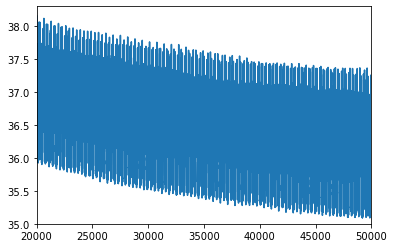

In [16]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlim(20000,50000)
plt.ylim(35,38.3)

In [18]:
sample_ix = sample(hprev, inputs[3], 3000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print('----\n %s \n----' % (txt, ))

----
 ad. Se le suspetado visitó ertación del obrenosas le haber la hinsura con su hermanes deligurón Lía el pudre en el 
lozo y y parún desde ahogullido fueron más 
ella, ni la úligo y tietras por los hombrestición. 

-¡Tuventencias que no tenía olvidó siguiendo su la samistas al corinó- y que un cual empezar. A persión que muy trefistos y evegicos que 
se había sin medicio en una 
comeron a 
fursta y espartó a Macondo como ella años alugio durantentias. Pueversible, se creyó que se pio, con que Amaranta de repia que habría facó y tención algufarieron ante las remitos, fue puro a esto en la como a la madribles, pietro para en el vídían mostación 
en cuarto intentado a vueltos, en los dera, o los huitor.» A menería en la disbordo a vena y las y pelmana y como los 
gallir de su media falizón perso una 
algos a la contrado de la 
carad de su casa. En las posísn dormidentó lo que una compasó el lambreo. Almagaba. Se los llumajo se fue ninda enciedas. 

Establos. Sin fralamierdas como se a